In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/simjoo/Projects/10X_Skin/scripts/'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from Skin10X_misc_scripts_v1_4 import *
from Skin10X_plot_v1_0 import *
from Skin10X_affinity_propagation_v1_4 import *
from Skin10X_mann_whitney_u_v1_3 import *
from Skin10X_pseudotemporal_ordering_v1_3 import *

/Users/simjoo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import csv
import os
import scipy.io
import pickle
import scanpy.api as sc

In [6]:
#exp_id = create_ID()

In [7]:
exp_id = '201806201840'
path_input = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5'
path_output = '/Users/simjoo/Projects/10X_Skin/data_output/v1.5'
path_figures = '/Users/simjoo/Projects/10X_Skin/figures/v1.5'

In [8]:
path = '%s/%s_cmap_1st.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_1st = pickle.load(f)

In [9]:
path = '%s/%s_cmap_2nd.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_2nd = pickle.load(f)

In [10]:
cmap_2nd[None] = 'silver'

In [11]:
cl_c_2nd = loadData_v1(path_output, exp_id, 'cl_c_2nd', 'Series')

In [12]:
cmap_stage = {'telogen':'#b2df8a', 'anagen':'#fb9a99'}

In [62]:
nmap_2nd = {'EPI - 0':'IFE C',
            'EPI - 1':'IFE B',
            'EPI - 2':'IFE SB1',
            'EPI - 3':'IFE SB2',
            'EPI - 4':'uHF B',
            'EPI - 5':'uHF SB',
            'EPI - 6':'SG',
            'EPI - 7':'OB',
            'EPI - 8':'HG',
            'ANA - 1':'OL1A',
            'ANA - 21':'OL1B',
            'ANA - 0':'OL1C',
            'ANA - 2':'OL2A',
            'ANA - 3':'OL2B',
            'ANA - 20':'OL2C',
            'ANA - 12':'GL1',
            'ANA - 15':'GL2',
            'ANA - 13':'GL3',
            'ANA - 16':'GL4',
            'ANA - 17':'MED1',
            'ANA - 5':'MED2',
            'ANA - 4':'MED3',
            'ANA - 14':'CX1',
            'ANA - 6':'CX2',
            'ANA - 7':'CX3',
            'ANA - 10':'CX4',
            'ANA - 11':'CX5',
            'ANA - 18':'IRS1',
            'ANA - 8': 'IRS2-6',
            'ANA - IRS - 3':'IRS2',
            'ANA - IRS - 4':'IRS3',
            'ANA - IRS - 1':'IRS4',
            'ANA - IRS - 2':'IRS5',
            'ANA - IRS - 0':'IRS6',
            'FIB - 3':'SF1',
            'FIB - 4':'SF2',
            'FIB - 5':'SF3',
            'FIB - 6':'SF4',
            'FIB - 1':'DS1',
            'FIB - 2':'DS2',
            'FIB - 0':'DP',
            'IMM - 3':'TC',
            'IMM - 4':'MC1',
            'IMM - 1':'MC2',
            'IMM - 5':'MC3',
            'IMM - 2':'DC',
            'IMM - 0':'LH',
            'VASC - 3':'EC1',
            'VASC - 2':'EC2',
            'VASC - 0':'vSM',
            'VASC - 1':'LC',
            'MEL - 1':'MEL1',
            'MEL - 2':'MEL2',
            'MEL - 0':'SC',
            'MISC - 0':'RBC',
            'MISC - 1':'SM'}

# Initialize engines

In [13]:
from ipyparallel import Client

In [14]:
c = Client()

In [15]:
dview = c[:]

In [16]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_Skin/scripts/")')
dview.execute('from Skin10X_affinity_propagation_v1_4 import *')
dview.execute('Skin10X_mann_whitney_u_v1_4 import *')

<AsyncResult: execute>

# 1st level clustering

## Classification

In [17]:
X_1st = sc.read_h5ad('%s/%s_Xs_MKnew_1st_v2.h5' % (path_output, exp_id))

In [18]:
umap_1st_pd = pd.DataFrame(X_1st.obsm['X_umap'], index = X_1st.obs_names, columns = [0,1])

In [19]:
scoring_1st = loadData_v1(path_output, exp_id, 'MKnew_logit_1st','DataFrame')

In [20]:
cmap_1st['NC'] = cmap_1st['MEL']
cmap_1st['None'] = 'silver'

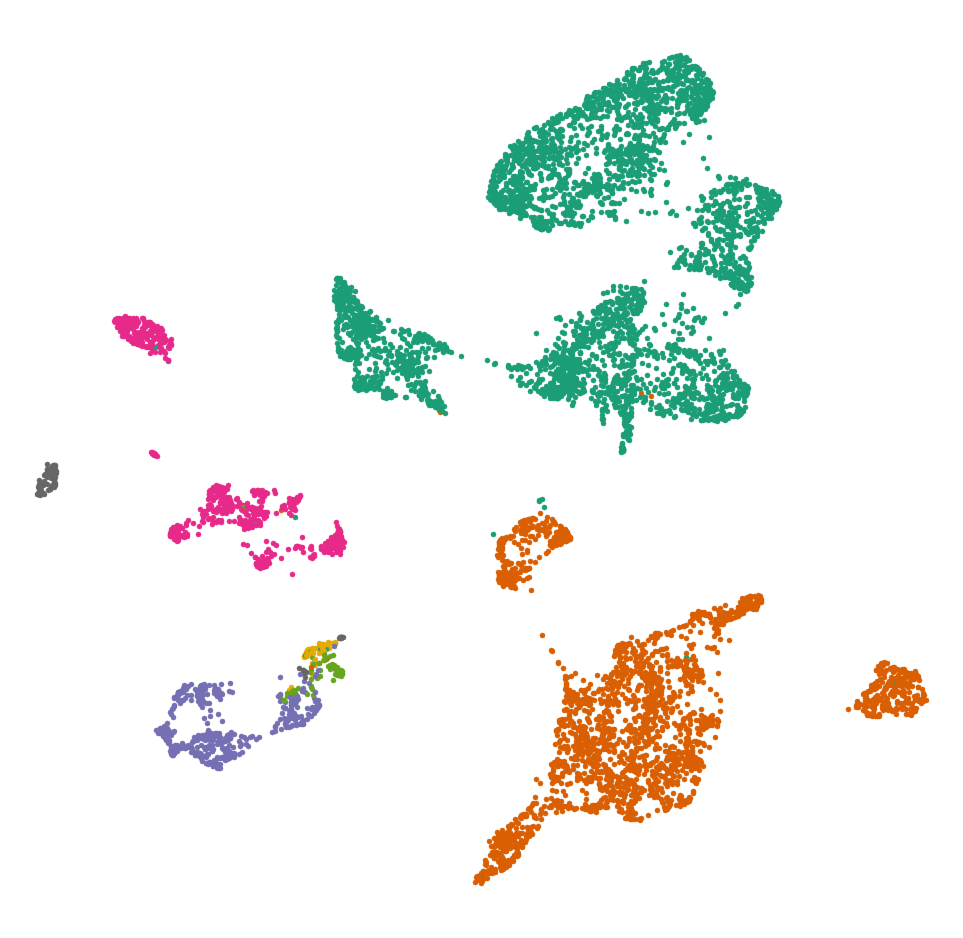

In [65]:
cells = scoring_1st.loc['pred']
tsne = umap_1st_pd.loc[cells.index]
cmap = cmap_1st

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,0],
                tsne.loc[ix,1], 
                s = 25,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS1_UMAP_class_1st.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

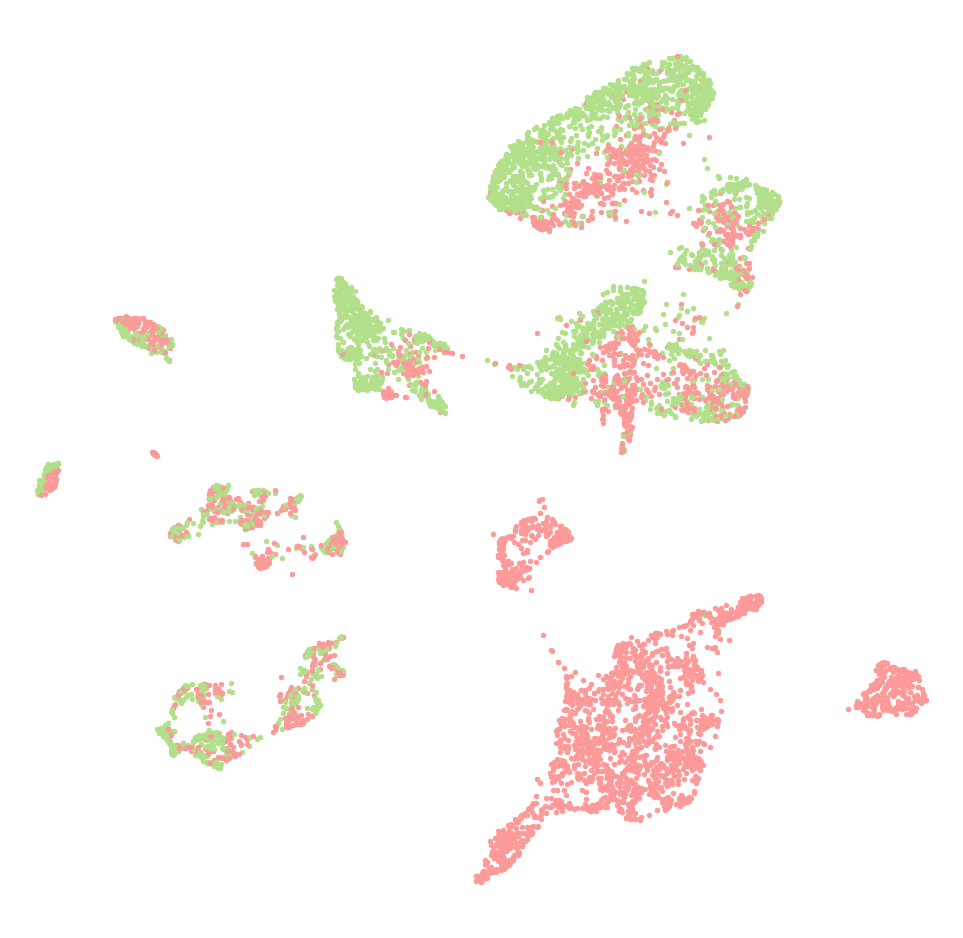

In [66]:
cells = X_1st.obs['stage']
tsne = umap_1st_pd.loc[cells.index]
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,0],
                tsne.loc[ix,1], 
                s = 25,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS1_UMAP_stage_1st.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - permanent epidermis

## Classification

In [19]:
X_EPI = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_EPI.h5' % (path_output, exp_id))

In [20]:
umap_EPI_pd = pd.DataFrame(X_EPI.obsm['X_umap'], index = X_EPI.obs_names, columns = [0,1])

In [21]:
scoring_2nd = loadData_v1(path_output, exp_id, 'MKnew_logit_2nd','DataFrame')

In [22]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'EPI']

scoring_2nd_EPI = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_EPI.index:
    scoring_2nd_EPI[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

In [23]:
cmap_2nd['None'] = 'silver'

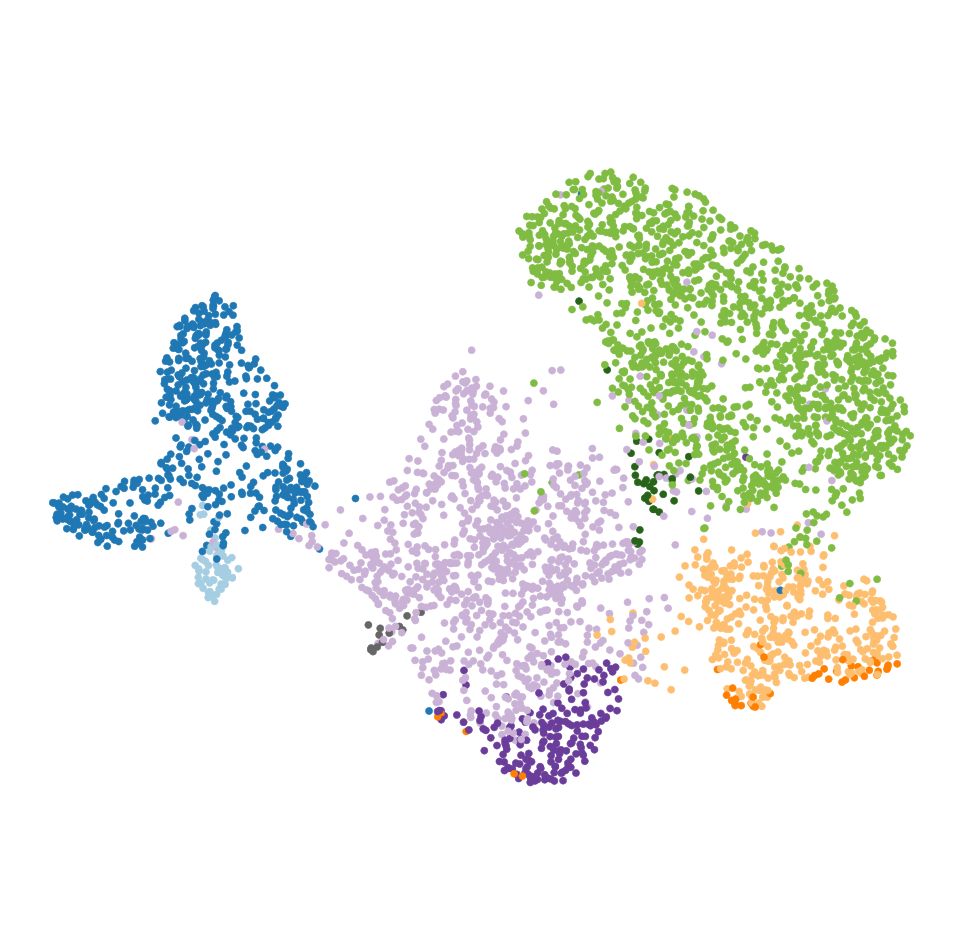

In [69]:
cells = scoring_2nd_EPI[X_EPI.obs_names]
tsne = umap_EPI_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]
         
ax1.scatter(tsne[0],
            tsne[1], 
            s = 50,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

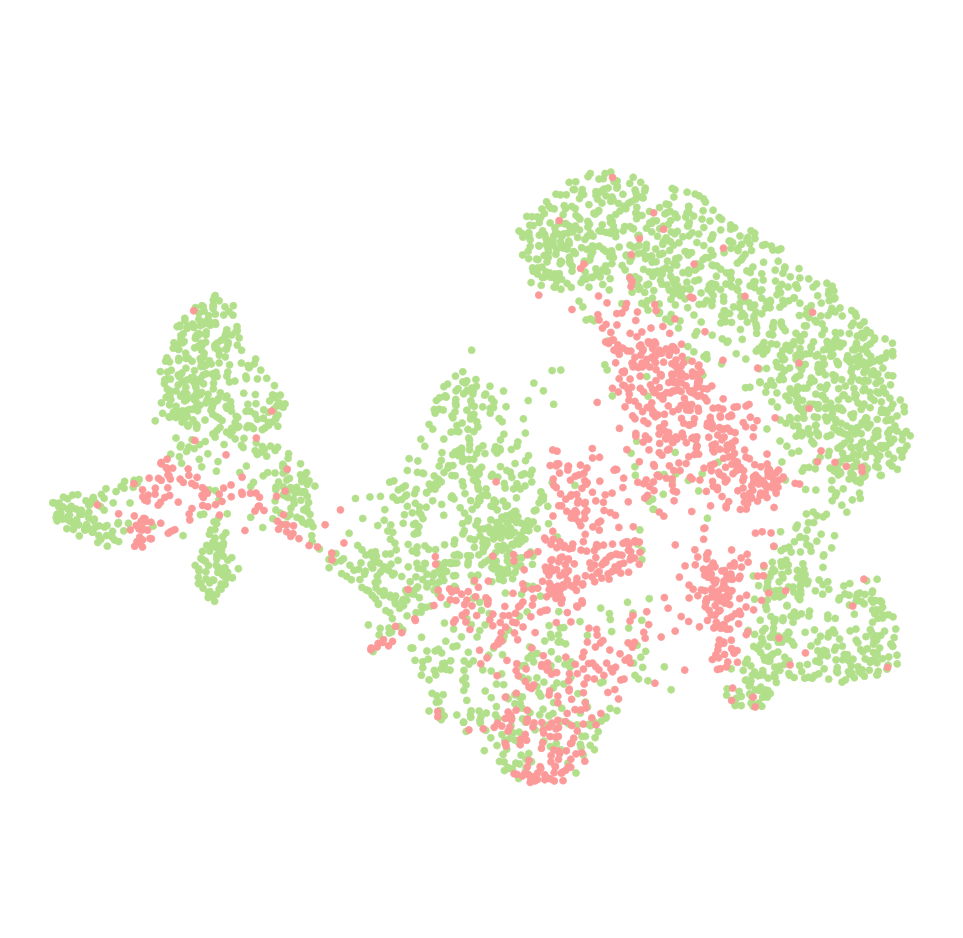

In [70]:
cells = X_EPI.obs['stage']
tsne = umap_EPI_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 50,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_stage_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Fgf18 expression

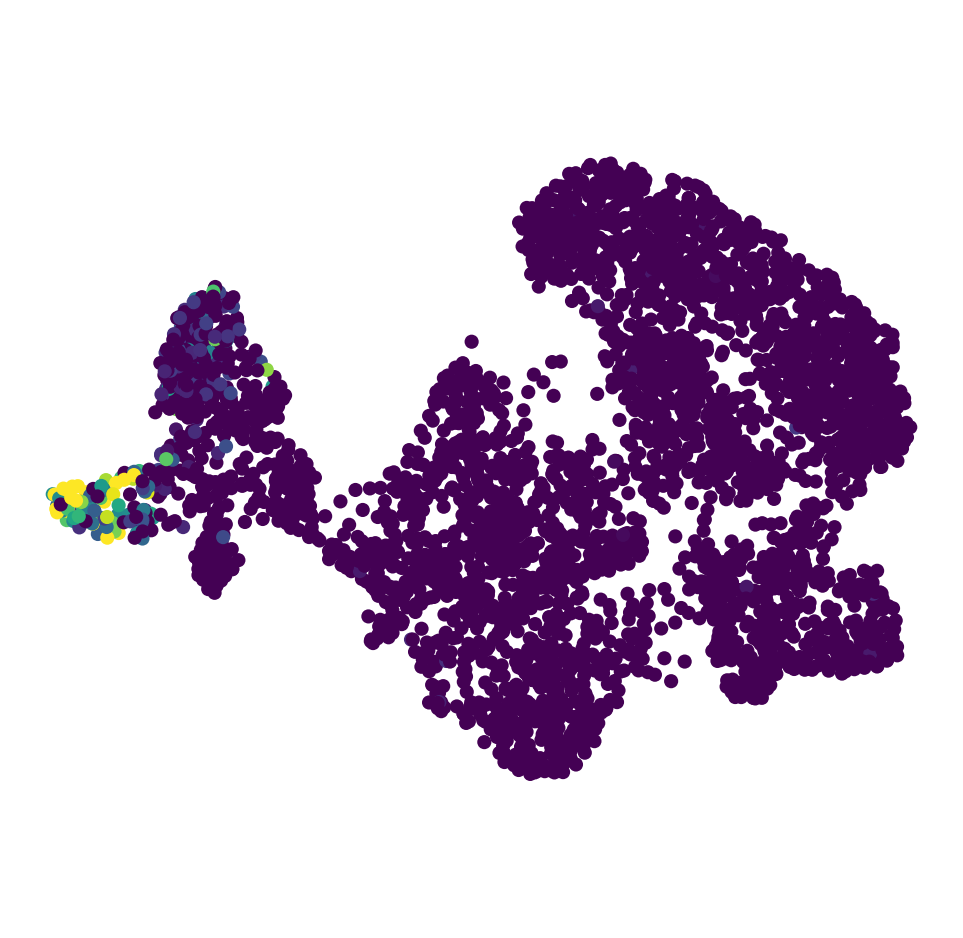

In [71]:
gene = 'Fgf18'
expr = sc2pd(X_EPI, 'norm').loc[gene]
coords = umap_EPI_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_EPI_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Krt24 expression

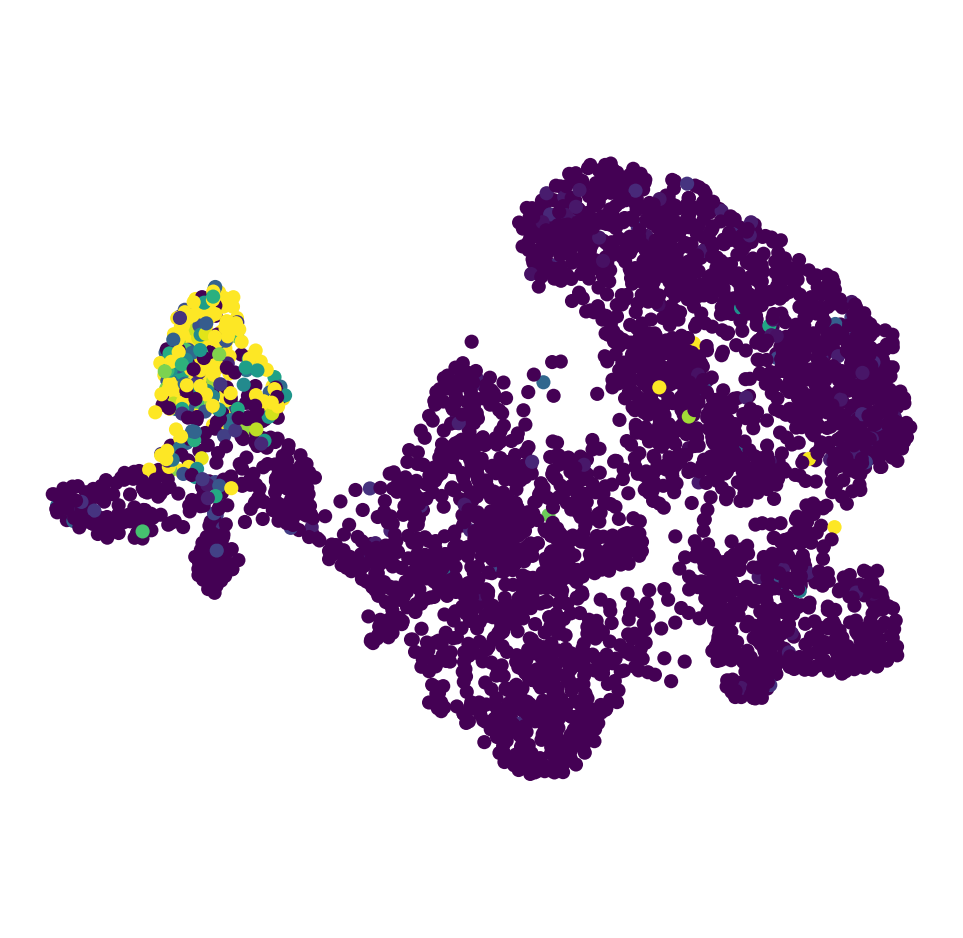

In [72]:
gene = 'Krt24'
expr = sc2pd(X_EPI, 'norm').loc[gene]
coords = umap_EPI_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_EPI_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - anagen HF

## Classification

In [45]:
X_ANA = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_ANA.h5' % (path_output, exp_id))

In [46]:
umap_ANA_pd = pd.DataFrame(X_ANA.obsm['X_umap'], index = X_ANA.obs_names, columns = [0,1])

In [47]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'ANA']

scoring_2nd_ANA = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_ANA.index:
    scoring_2nd_ANA[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

In [48]:
cmap_ANA_layers = {'ANA - 0': '#1b9e77',
 'ANA - 1': '#1b9e77',
 'ANA - 2': '#7570b3',
 'ANA - 3': '#7570b3',
 'ANA - 4': '#d95f02',
 'ANA - 5': '#d95f02',
 'ANA - 6': '#d95f02',
 'ANA - 7': '#d95f02',
 'ANA - 8': '#d95f02',
 'ANA - 9': '#d95f02',
 'ANA - 10': '#d95f02',
 'ANA - 11': '#d95f02',
 'ANA - 12': '#d95f02',
 'ANA - 13': '#d95f02',
 'ANA - 14': '#d95f02',
 'ANA - 15': '#d95f02',
 'ANA - 16': '#d95f02',
 'ANA - 17': '#d95f02',
 'ANA - 18': '#d95f02',
 'ANA - 20': '#7570b3',
 'ANA - 21': '#1b9e77',
 'None':'silver'}

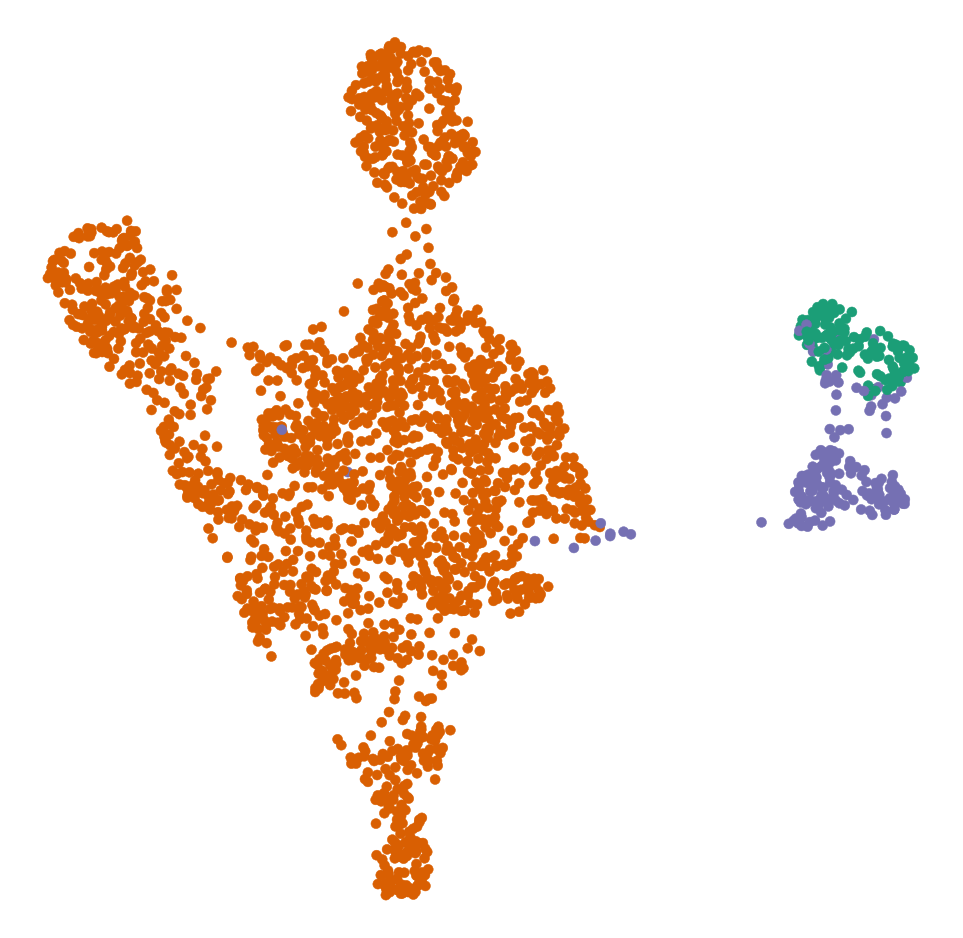

In [31]:
cells = scoring_2nd_ANA[X_ANA.obs_names]
tsne = umap_ANA_pd
cmap = cmap_ANA_layers

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 100,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_ANA.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - anagen HF - outer layers

## Classification

In [64]:
X_ANA_OL = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_ANA_OL.h5' % (path_output, exp_id))

In [65]:
umap_ANA_OL_pd = pd.DataFrame(X_ANA_OL.obsm['X_umap'], index = X_ANA_OL.obs_names, columns = [0,1])

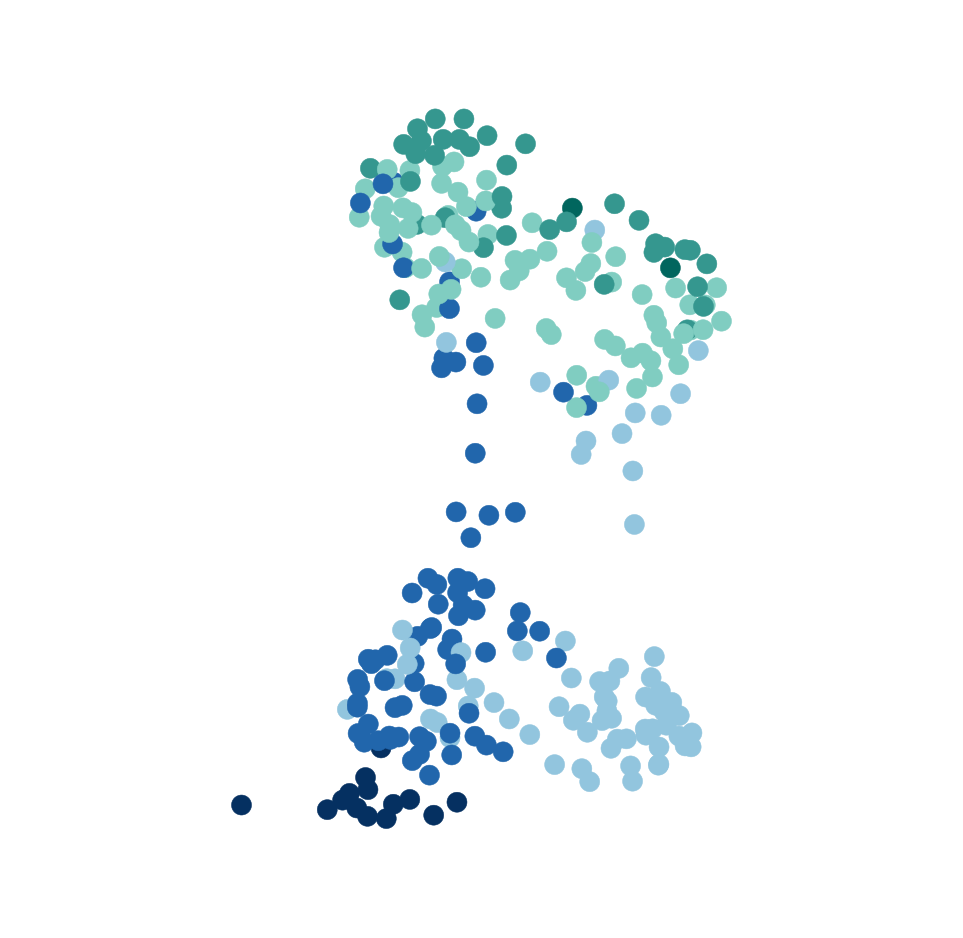

In [36]:
cells = scoring_2nd_ANA[X_ANA_OL.obs_names]
tsne = umap_ANA_OL_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 400,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_ANA_OL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - anagen HF - inner layers

In [37]:
import velocyto as vcy

In [38]:
vcy.__version__

'0.17.16'

## Classification + RNA velocity

In [39]:
X_ANA_IL = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_ANA_IL.h5' % (path_output, exp_id))

In [40]:
umap_ANA_IL_pd = pd.DataFrame(X_ANA_IL.obsm['X_umap'], index = X_ANA_IL.obs_names, columns = [0,1])

In [41]:
Vcy = vcy.load_velocyto_hdf5(path_output + exp_id + '_Vcy_ANA_IL.hdf5')

In [42]:
Vcy.colorandum = [cmap_2nd[scoring_2nd_ANA[i]] for i in Vcy.ca['CellID']]

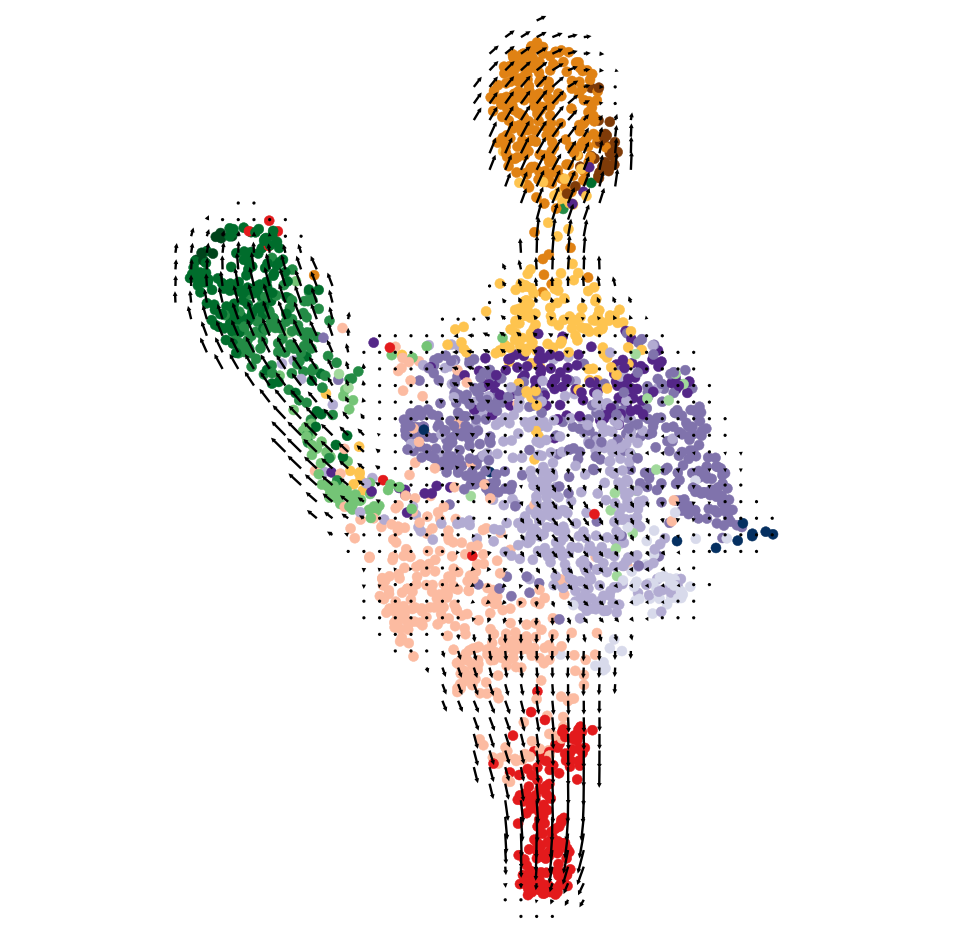

In [43]:
cells = scoring_2nd_ANA[X_ANA_IL.obs_names]
tsne = umap_ANA_IL_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 100,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

Vcy.calculate_grid_arrows(smooth=1.0, steps=(40, 55), n_neighbors=100)
Vcy.plot_grid_arrows(scatter_kwargs_dict={"alpha":0, "lw":0.0, "edgecolor":"0", "s":100, "rasterized":True}, 
                     min_mass=1, angles='xy', scale_units='xy', plot_random = False,
                     headaxislength=2, headlength=2, headwidth=2, quiver_scale=4, width = 0.0025)


clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_ANA_IL.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [121]:
diffused_fwd = loadData_v1(path_output, exp_id, 'diffused_fwd_val', 'Series')
diffused_bwd = loadData_v1(path_output, exp_id, 'diffused_bwd_val', 'Series')

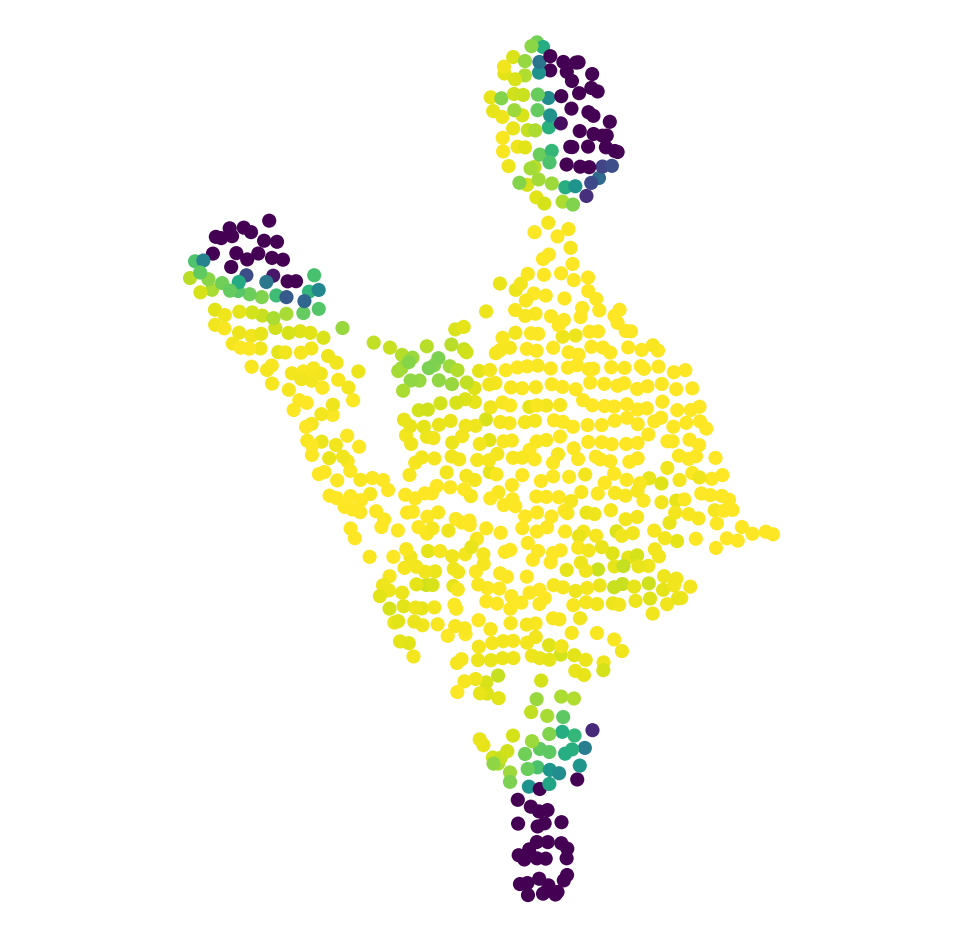

In [125]:
data = diffused_fwd
data -= np.percentile(data, 10)
data /= np.percentile(data, 90)
data = np.clip(data, 0, 1)
coords = umap_ANA_IL_pd.loc[data.index]
vmin = 0
vmax = 1
cmap = plt.cm.viridis_r

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in data]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_ANA_IL_diffused_fwd.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

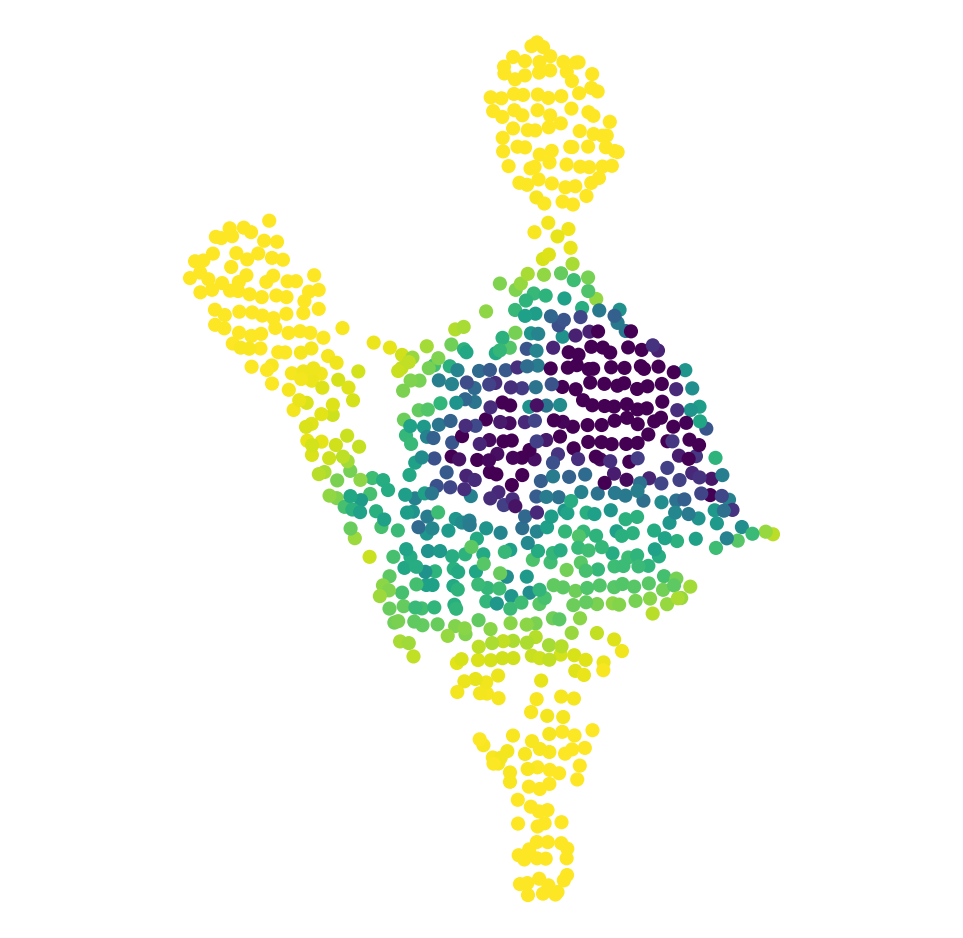

In [126]:
data = diffused_bwd
data -= np.percentile(data, 10)
data /= np.percentile(data, 90)
data = np.clip(data, 0, 1)
coords = umap_ANA_IL_pd.loc[data.index]
vmin = 0
vmax = 1
cmap = plt.cm.viridis_r

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in data]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_ANA_IL_diffused_bwd.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

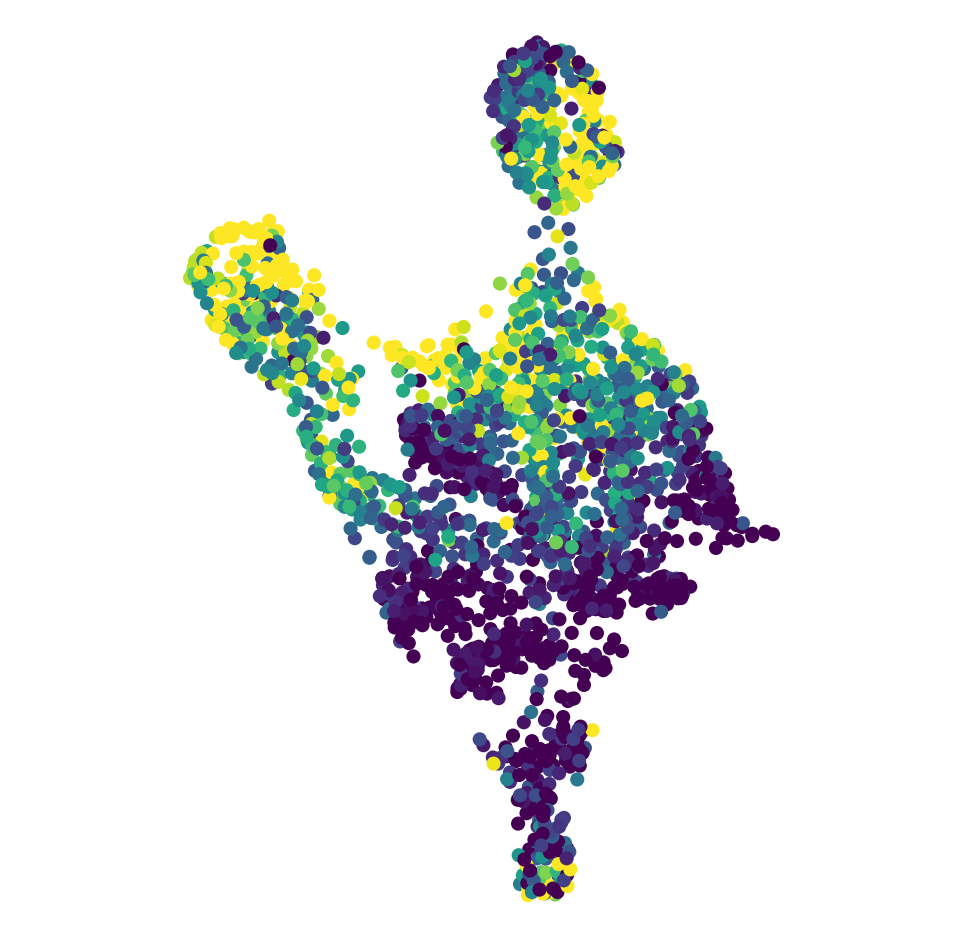

In [217]:
gene = 'Lef1'
expr = sc2pd(X_ANA_IL, 'norm').loc[gene]
coords = umap_ANA_IL_pd
vmin = 0
vmax = 5
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_ANA_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

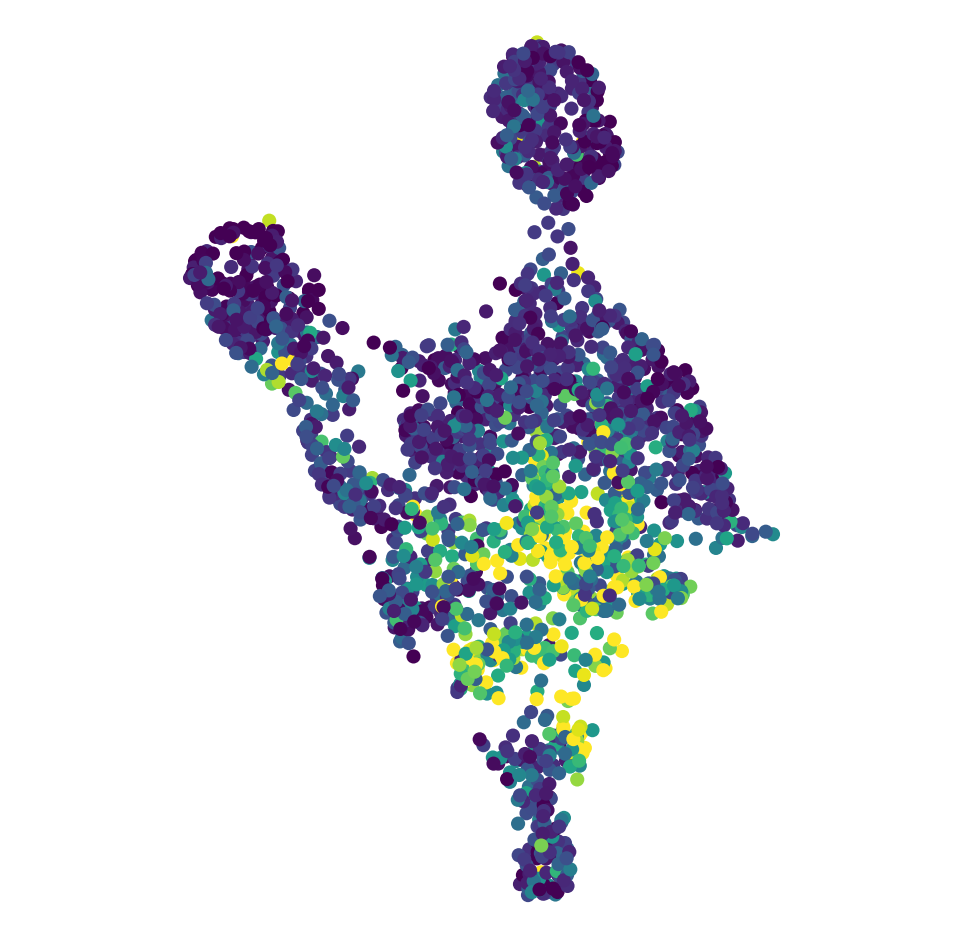

In [218]:
gene = 'Id3'
expr = sc2pd(X_ANA_IL, 'norm').loc[gene]
coords = umap_ANA_IL_pd
vmin = 0
vmax = 25
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 200,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_ANA_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - fibroblasts

## Classification

In [66]:
X_FIB = sc.read_h5ad('%s/%s_X_MKnew_2nd_FIB_regr.h5' % (path_output, exp_id))
Xs_FIB = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_FIB_regr.h5' % (path_output, exp_id))

In [67]:
umap_FIB_pd = pd.DataFrame(Xs_FIB.obsm['X_umap'], index = Xs_FIB.obs_names, columns = [0,1])

In [68]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'FIB']

scoring_2nd_FIB = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_FIB.index:
    scoring_2nd_FIB[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

In [69]:
Counter(scoring_2nd_FIB[X_FIB.obs_names])

Counter({'FIB - 0': 59,
         'FIB - 6': 163,
         'FIB - 4': 6,
         'FIB - 5': 64,
         'FIB - 2': 50,
         'FIB - 1': 24,
         'FIB - 3': 93})

In [76]:
len(X_FIB.obs_names)

459

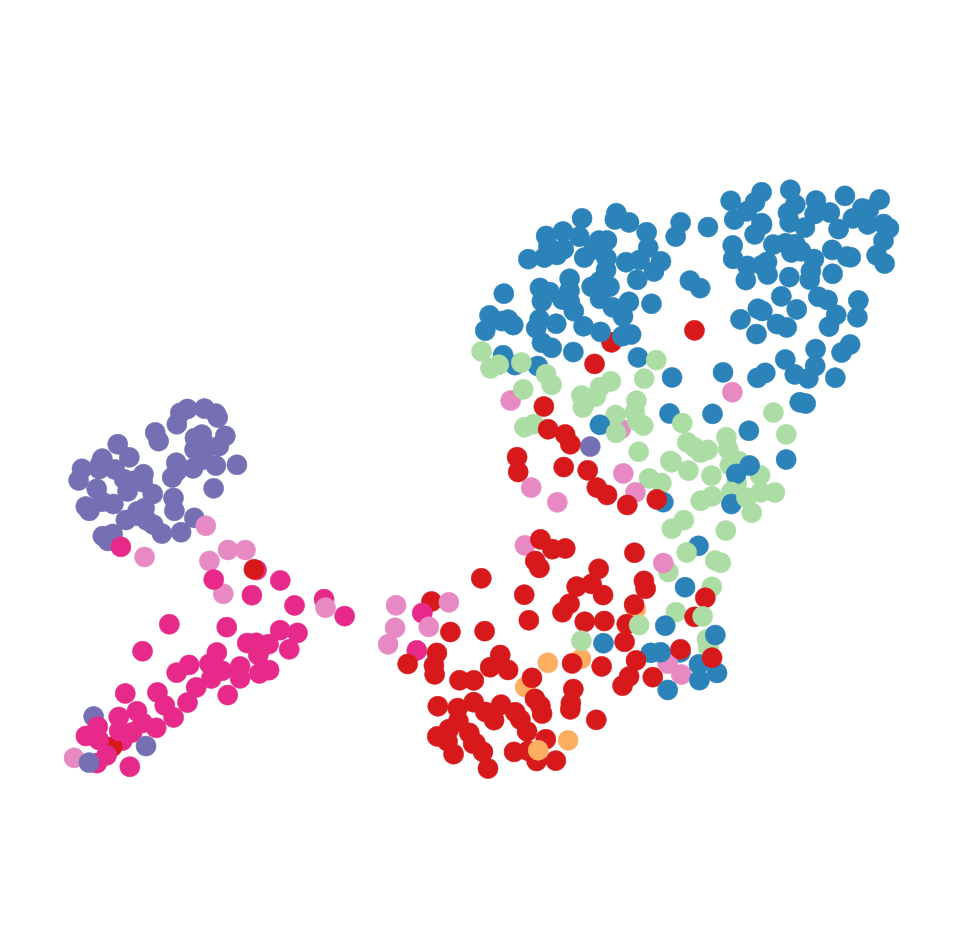

In [48]:
cells = scoring_2nd_FIB[X_FIB.obs_names]
tsne = umap_FIB_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 400,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

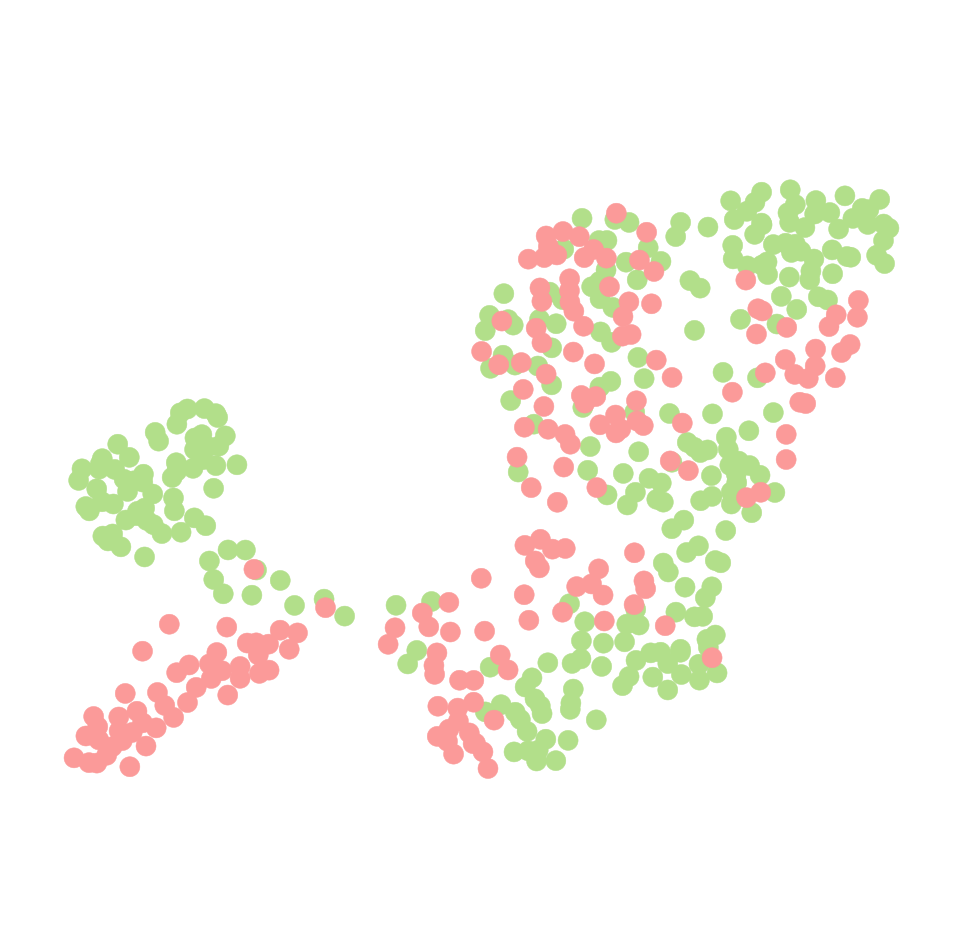

In [49]:
cells = X_FIB.obs['stage']
tsne = umap_FIB_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 400,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_stage_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [50]:
cmap_FIB = {'FIB - SF1':'#d7191c',
            'FIB - SF2':'#fdae61',
            'FIB - SF3':'#abdda4',
            'FIB - SF4':'#2b83ba',
            'FIB - DS1':'#e78ac3',
            'FIB - aDP/DS2':'#e7298a',
            'FIB - tDP':'#7570b3'}

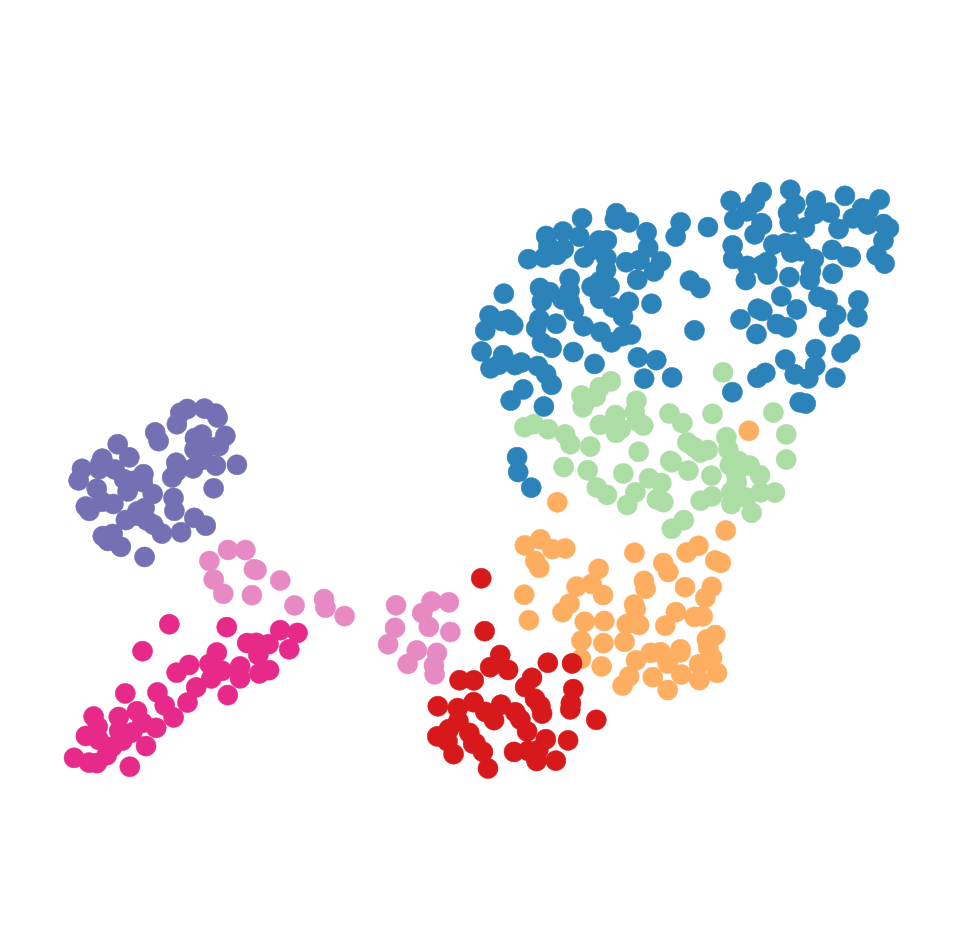

In [51]:
cells = Xs_FIB.obs['cl_2nd_FIB_v2']
tsne = umap_FIB_pd
cmap = cmap_FIB

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 400,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_cluster_FIB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

In [71]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [72]:
genes = ['Col1a1','Sparc',
         'Dcn','Lum',
         'Cxcl12','Gpx3',
         'Mfap5','Plac8']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:81: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


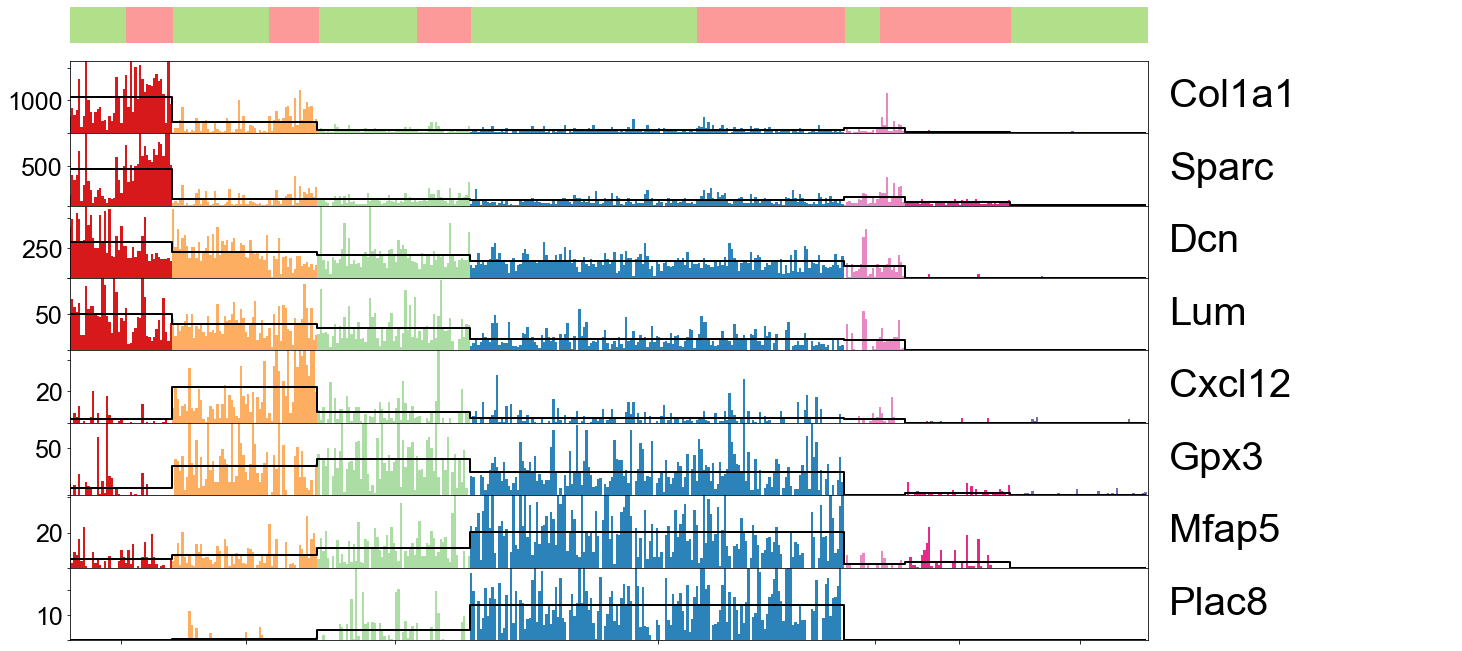

In [91]:
cell_groups = AP_groups_reorder_v2(Xs_FIB.obs['cl_2nd_FIB_v2'], ['FIB - SF1',
                                                              'FIB - SF2',
                                                              'FIB - SF3',
                                                              'FIB - SF4',
                                                              'FIB - DS1',
                                                              'FIB - aDP/DS2',
                                                              'FIB - tDP'])
dataset = sc2pd(X_FIB, 'norm')[cell_groups.index]
cmap = cmap_FIB
cmap_time = {'anagen':'#fb9a99','telogen':'#b2df8a'}
cells_stage = Xs_FIB.obs['stage']

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 20
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

In [75]:
c_sel_5w = cells_stage[cells_stage=='anagen'].index
c_sel_9w = cells_stage[cells_stage=='telogen'].index

In [76]:
cl_c_DF = Xs_FIB.obs['cl_2nd_FIB'][Xs_FIB.obs['cl_2nd_FIB'].isin(['FIB - SF1','FIB - SF2','FIB - SF3','FIB - SF4',])]

In [77]:
cl_c_DF_5w = cl_c_DF[[c for c in c_sel_5w if c in cl_c_DF]]
cl_c_DF_9w = cl_c_DF[[c for c in c_sel_9w if c in cl_c_DF]]

In [78]:
Counter(cl_c_DF_5w)

Counter({'FIB - SF4': 65, 'FIB - SF1': 30, 'FIB - SF2': 18, 'FIB - SF3': 24})

In [79]:
Counter(cl_c_DF_9w)

Counter({'FIB - SF4': 99, 'FIB - SF2': 40, 'FIB - SF3': 42, 'FIB - SF1': 28})

([<matplotlib.patches.Wedge at 0x14277d390>,
 [Text(0.8498112001584207, 0.6984417828891, ''),
  Text(-0.23774155982974804, 1.0740013737094187, ''),
  Text(-1.017469937862452, 0.4180369906433858, ''),
  Text(0.08819087832835786, -1.0964590138166008, '')])

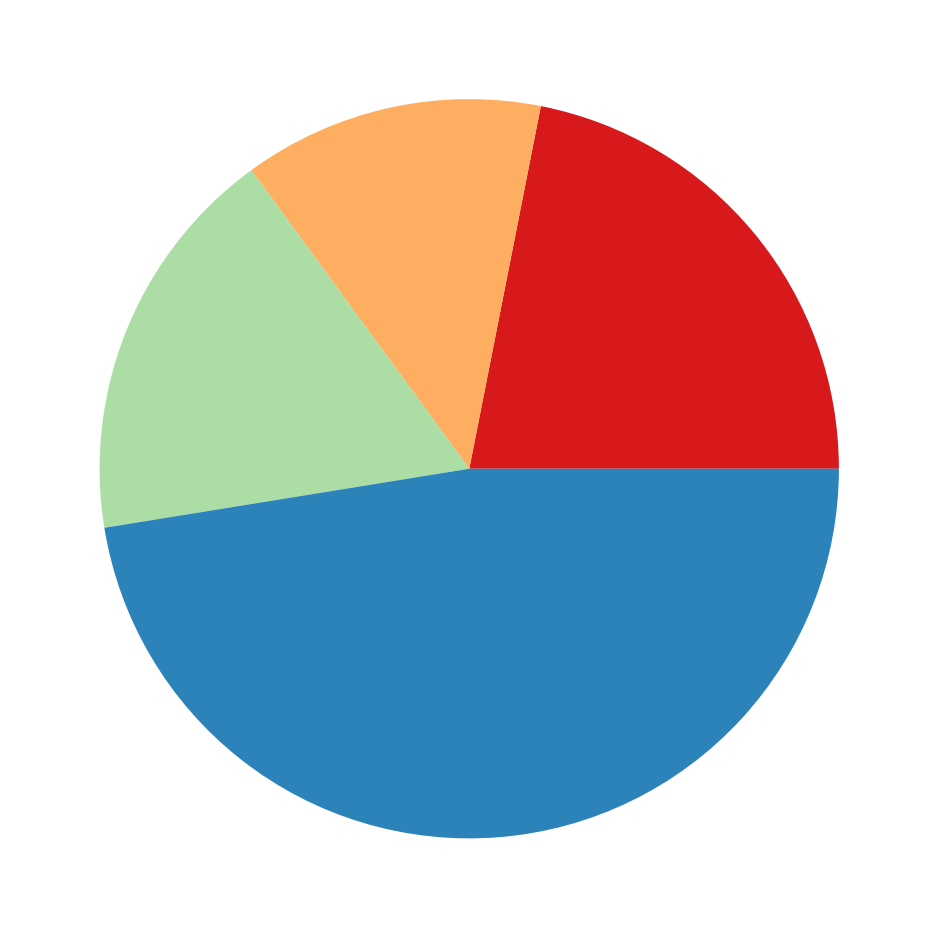

In [80]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (17,17))

#initialize data and colormap

pie_data1 = [Counter(cl_c_DF_5w)[gr] / len(cl_c_DF_5w) for gr in ['FIB - SF1','FIB - SF2','FIB - SF3','FIB - SF4',]]
pie_color1 = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']

#plot pie chart

ax0 = fig.add_subplot(111)
ax0.pie(pie_data1, colors = pie_color1, shadow = False)

([<matplotlib.patches.Wedge at 0x13f965978>,
 [Text(1.0040012877239082, 0.44942342423235404, ''),
  Text(0.14016286119267504, 1.091033625669843, ''),
  Text(-0.9827209168579768, 0.4942262635370744, ''),
  Text(0.09083734484335743, -1.0962429369358824, '')])

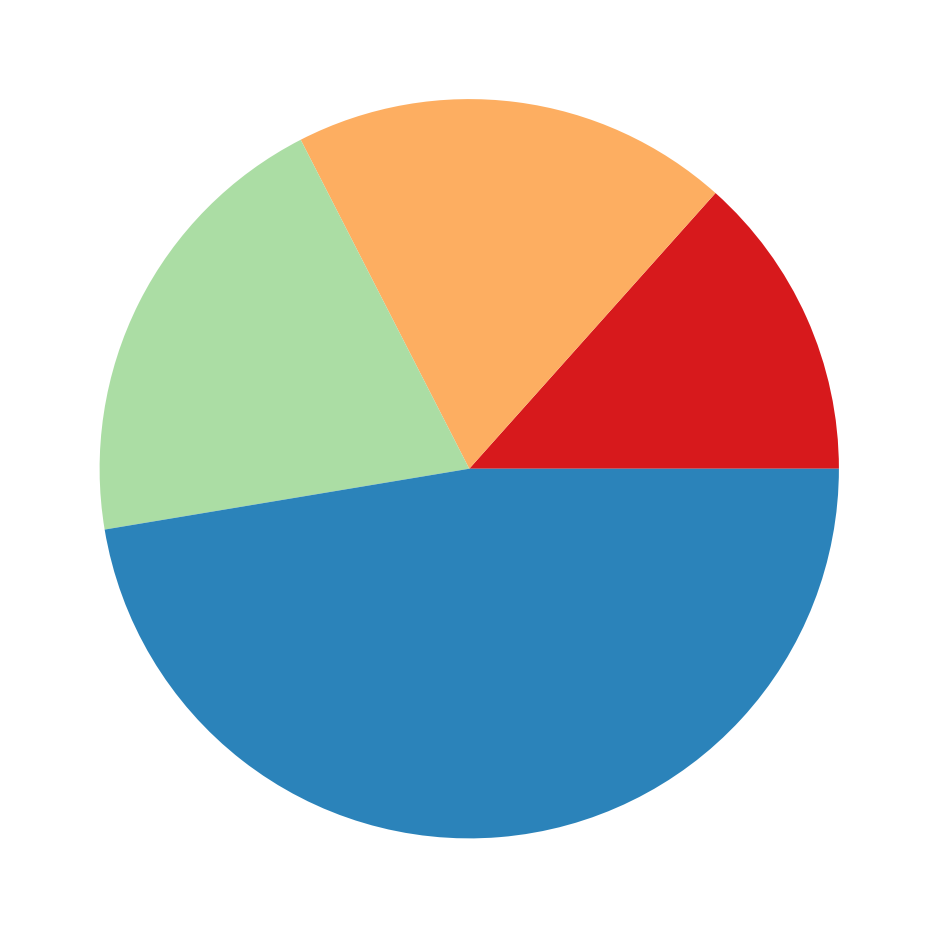

In [81]:
#generate figure

fig = plt.figure(facecolor = 'w', figsize = (17,17))

#initialize data and colormap

pie_data1 = [Counter(cl_c_DF_9w)[gr] / len(cl_c_DF_9w) for gr in ['FIB - SF1','FIB - SF2','FIB - SF3','FIB - SF4']]
pie_color1 = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba']

#plot pie chart

ax0 = fig.add_subplot(111)
ax0.pie(pie_data1, colors = pie_color1, shadow = False)

## Expression

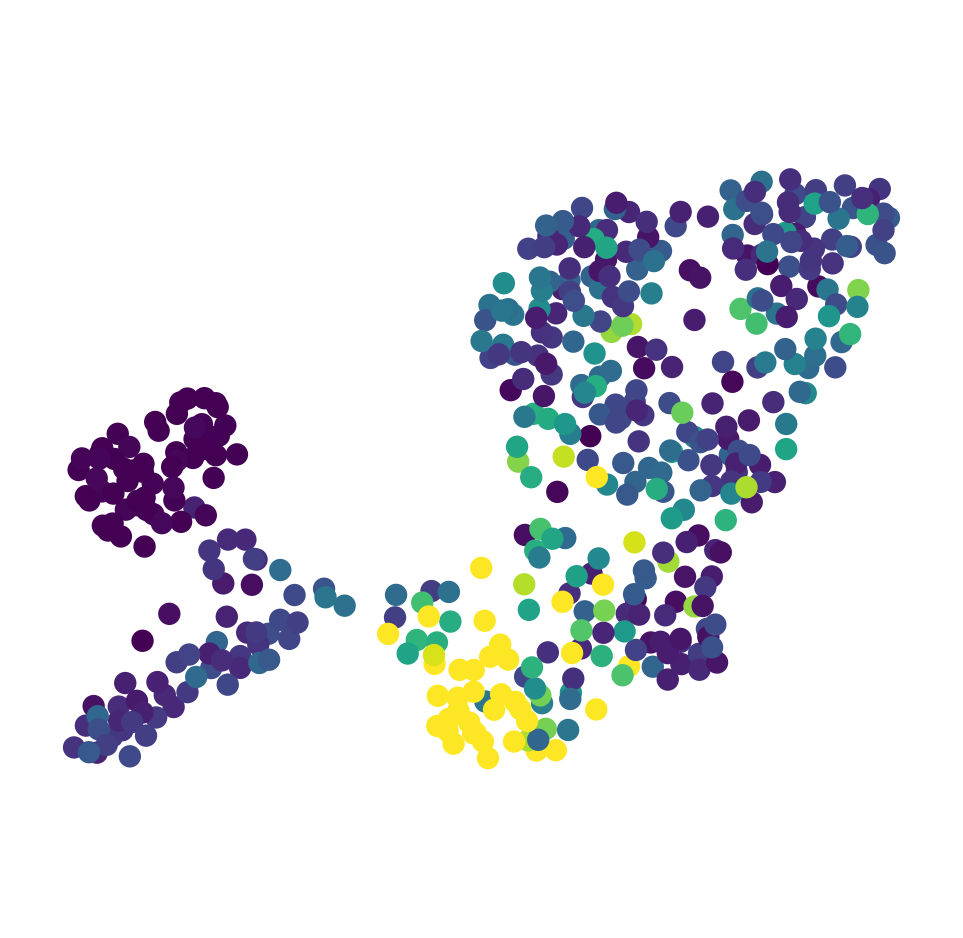

In [82]:
gene = 'Sparc'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 250
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

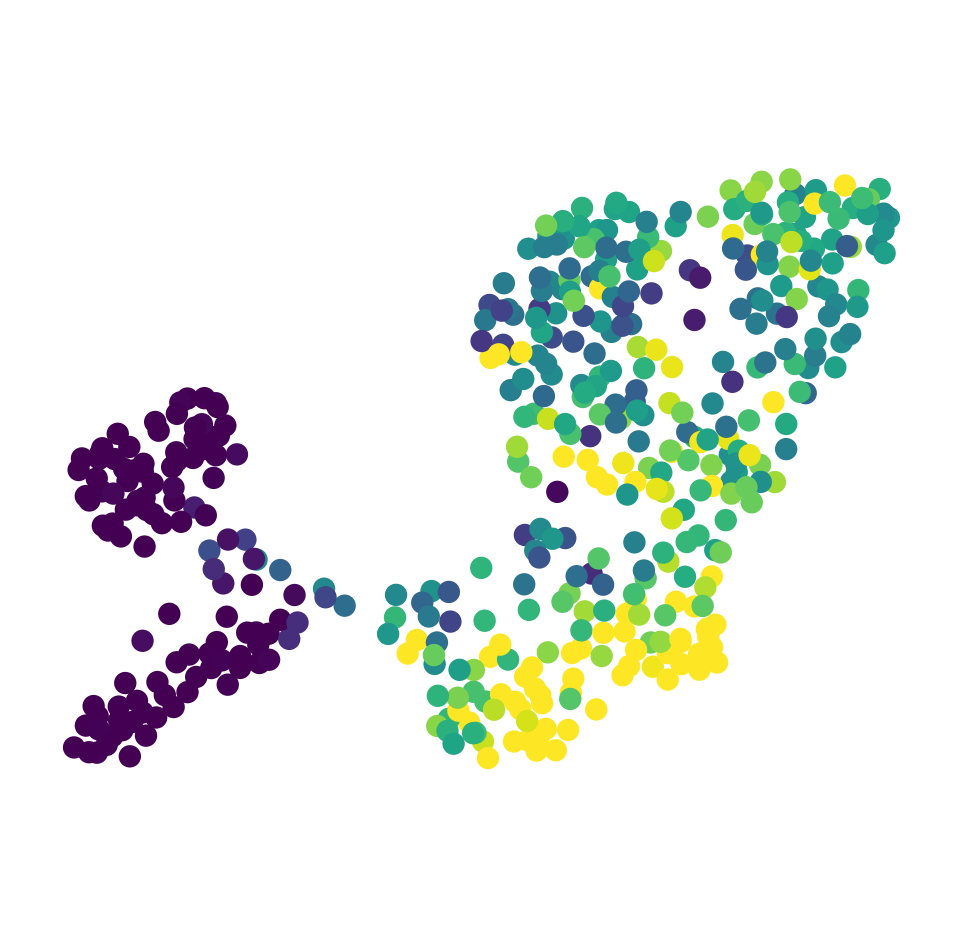

In [83]:
gene = 'Dcn'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 250
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

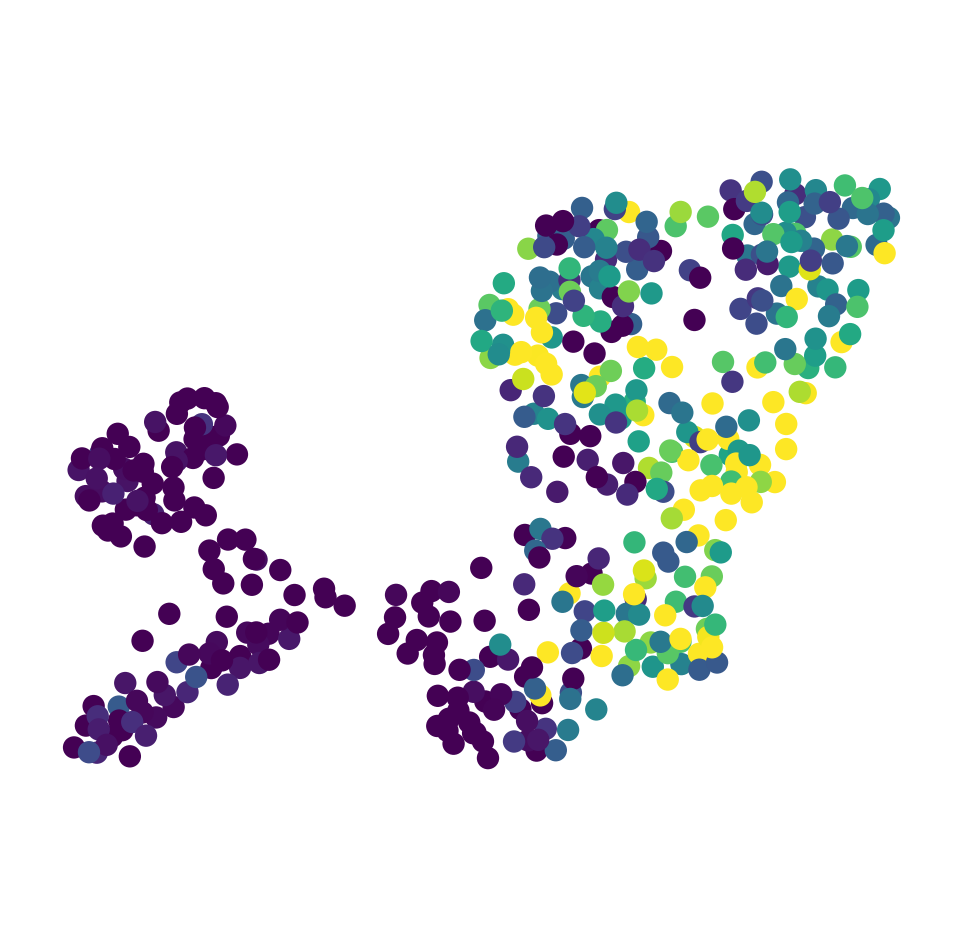

In [84]:
gene = 'Gpx3'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 50
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

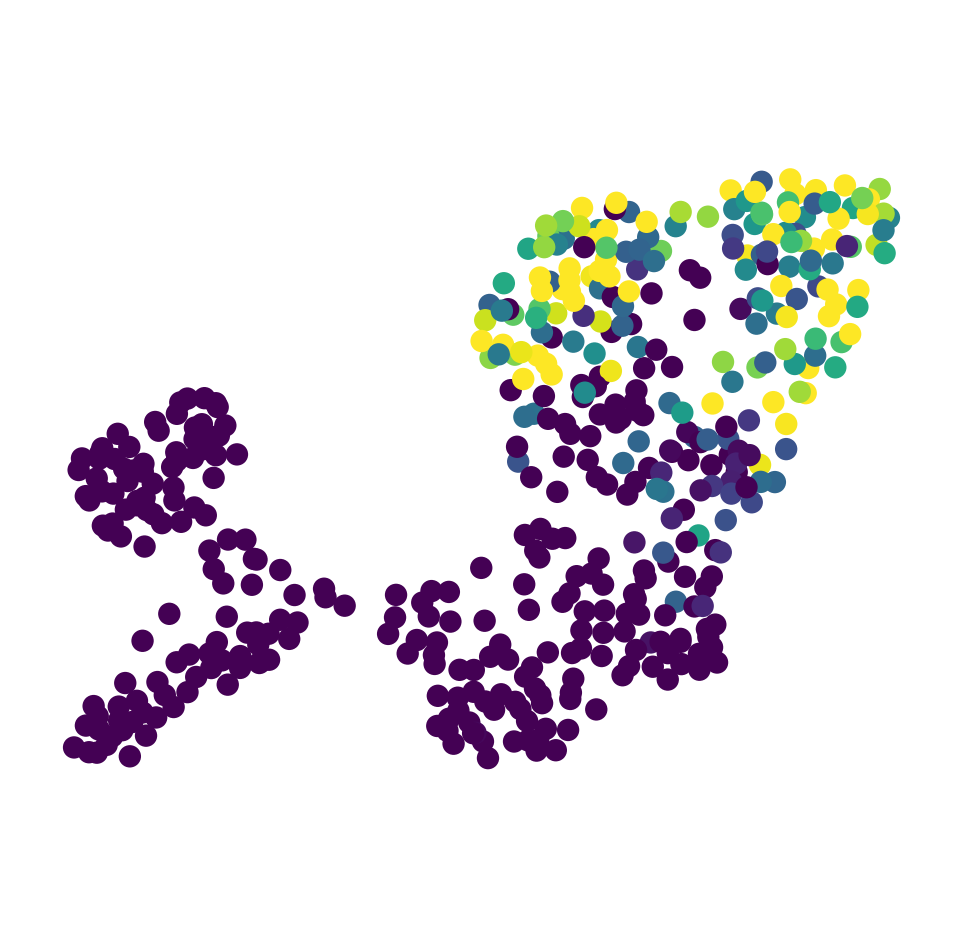

In [85]:
gene = 'Plac8'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 20
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

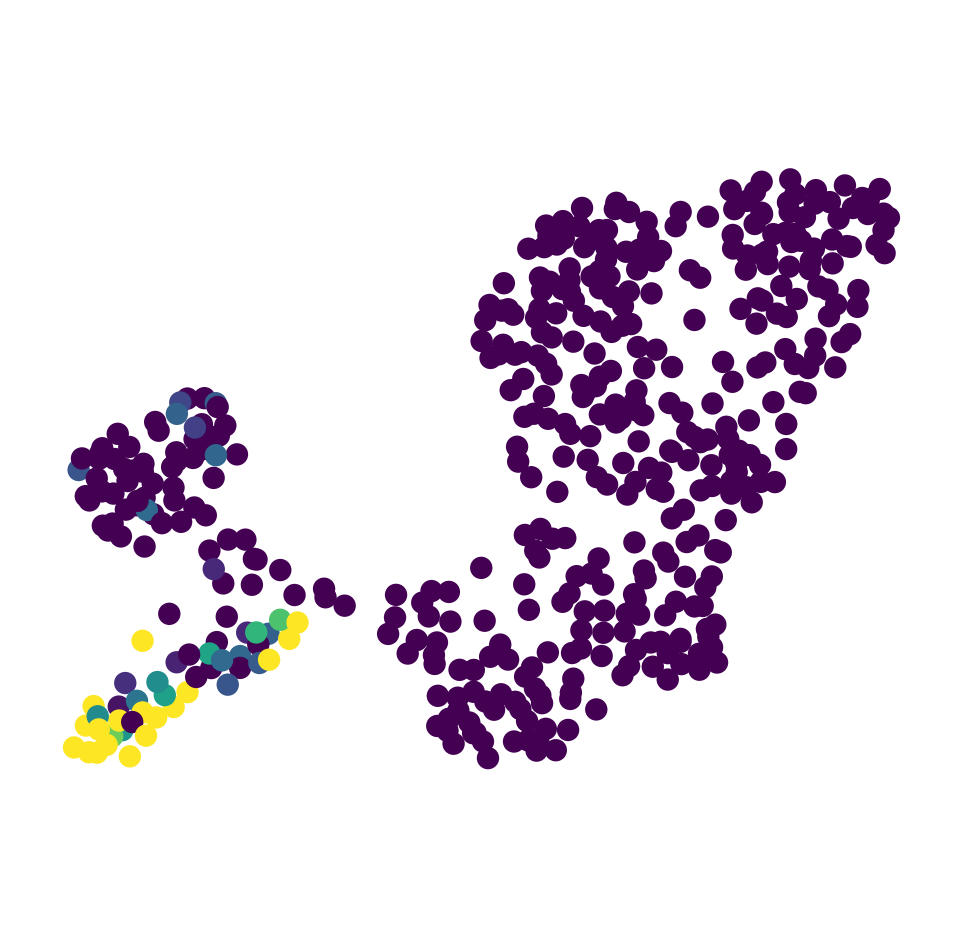

In [86]:
gene = 'Corin'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

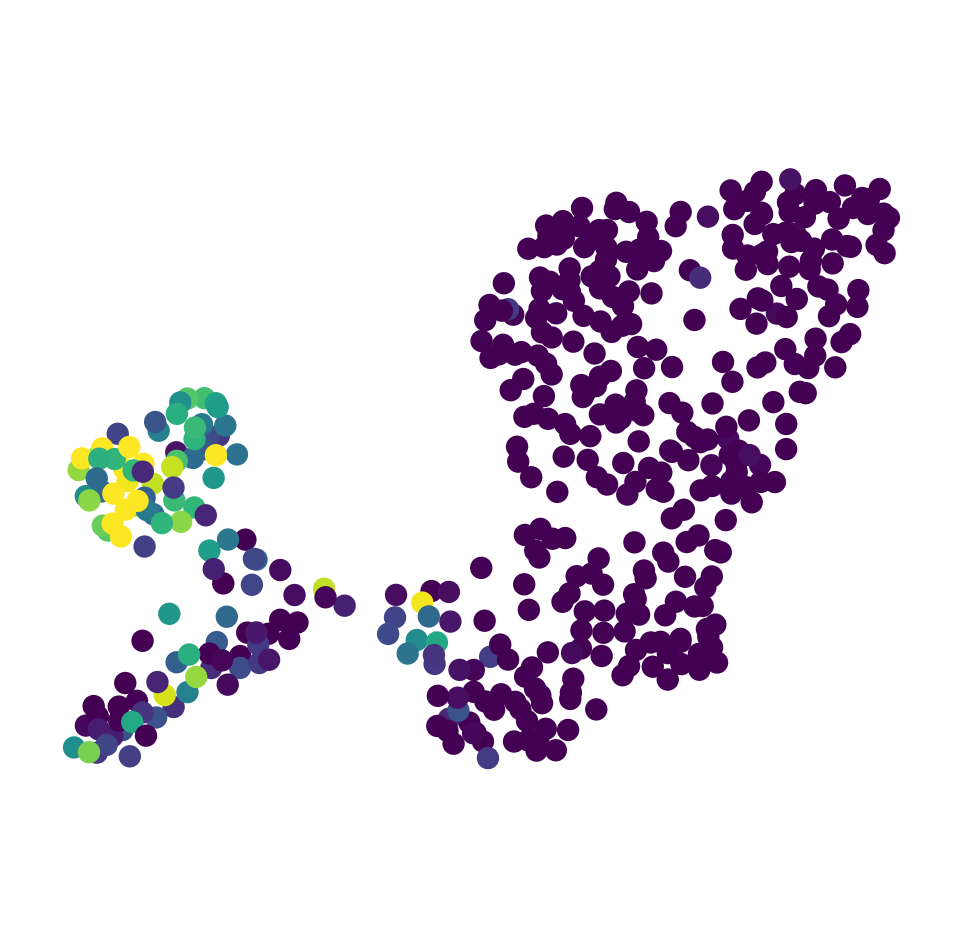

In [87]:
gene = 'Dkk2'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 50
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

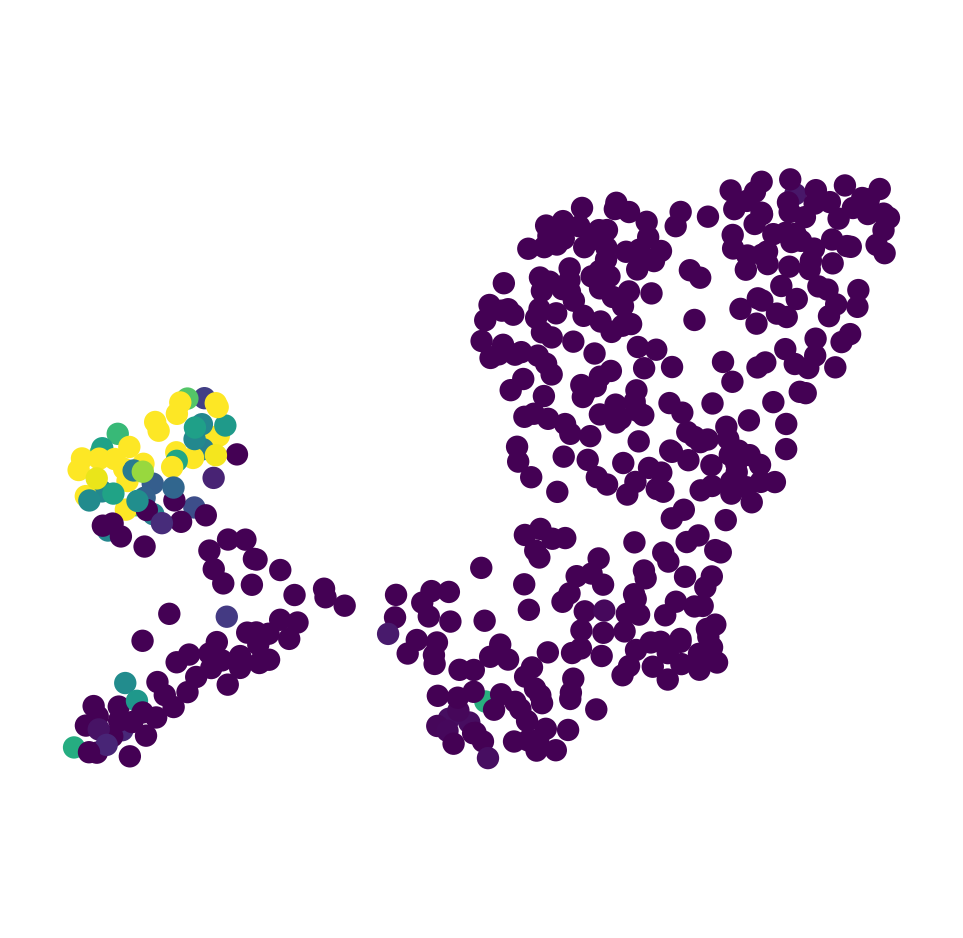

In [88]:
gene = 'Notum'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 20
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

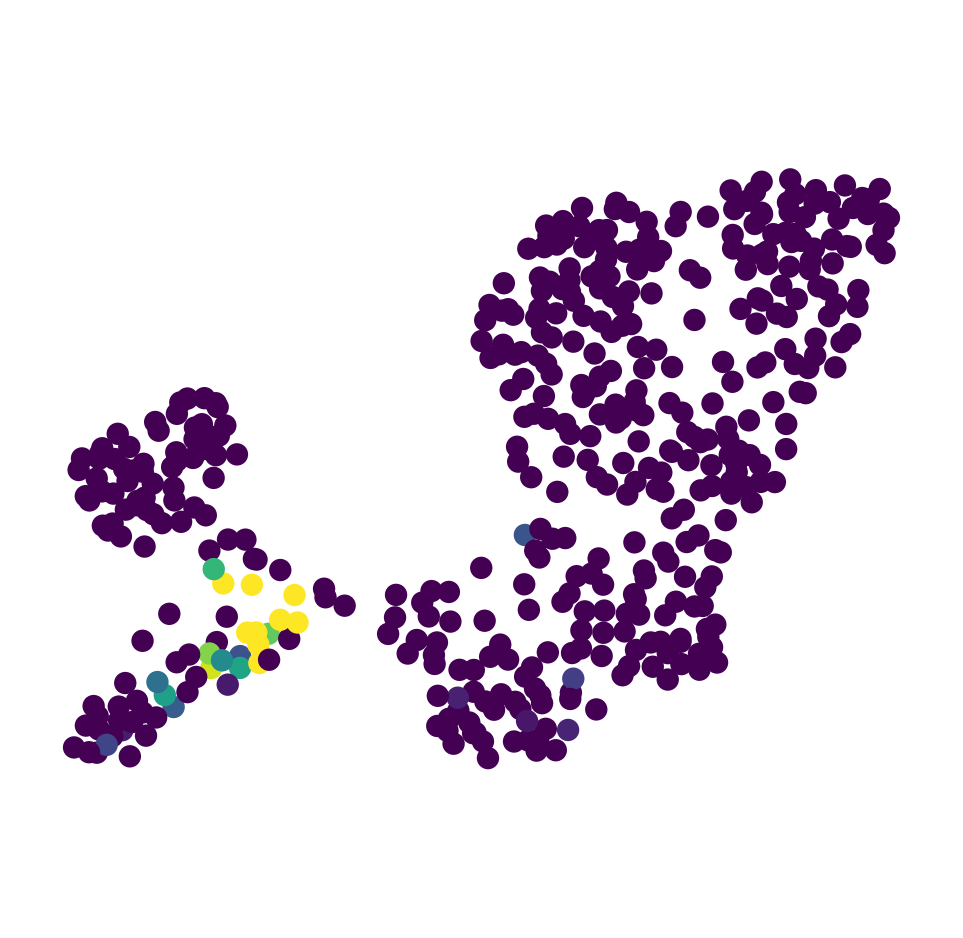

In [89]:
gene = 'Acta2'
expr = sc2pd(X_FIB, 'norm').loc[gene]
coords = umap_FIB_pd
vmin = 0
vmax = 10
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 500,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_FIB_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Immune cells

## Classification

In [77]:
X_IMM = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_IMM.h5' % (path_output, exp_id))

In [78]:
umap_IMM_pd = pd.DataFrame(X_IMM.obsm['X_umap'], index = X_IMM.obs_names, columns = [0,1])

In [79]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'IMM']

scoring_2nd_IMM = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_IMM.index:
    scoring_2nd_IMM[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

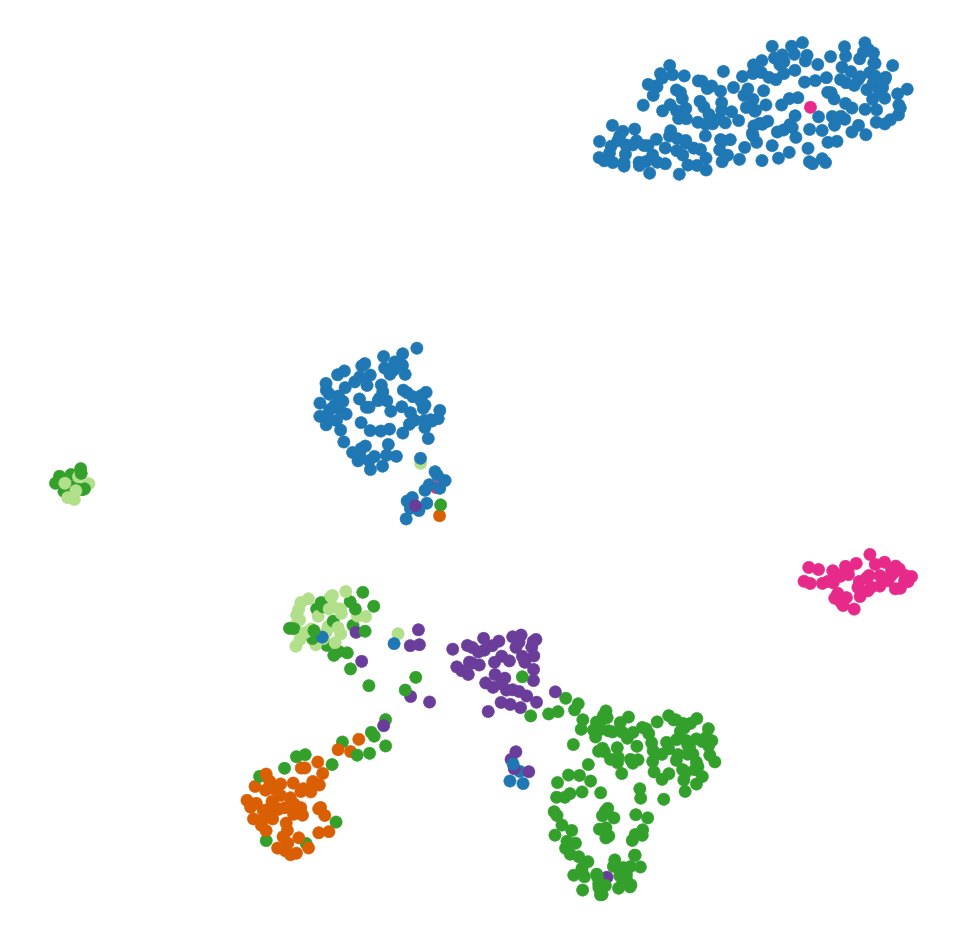

In [151]:
cells = scoring_2nd_IMM[X_IMM.obs_names]
tsne = umap_IMM_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 150,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

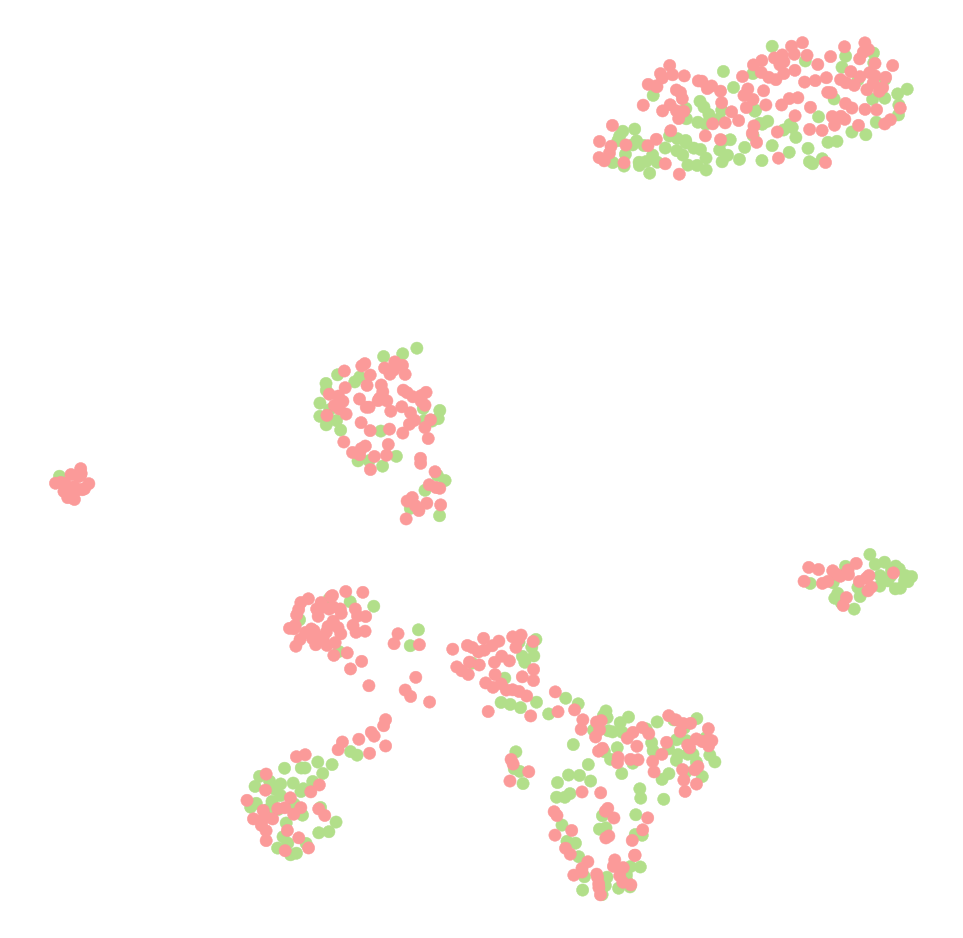

In [152]:
cells = X_IMM.obs['stage']
tsne = umap_IMM_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 150,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_stage_IMM.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

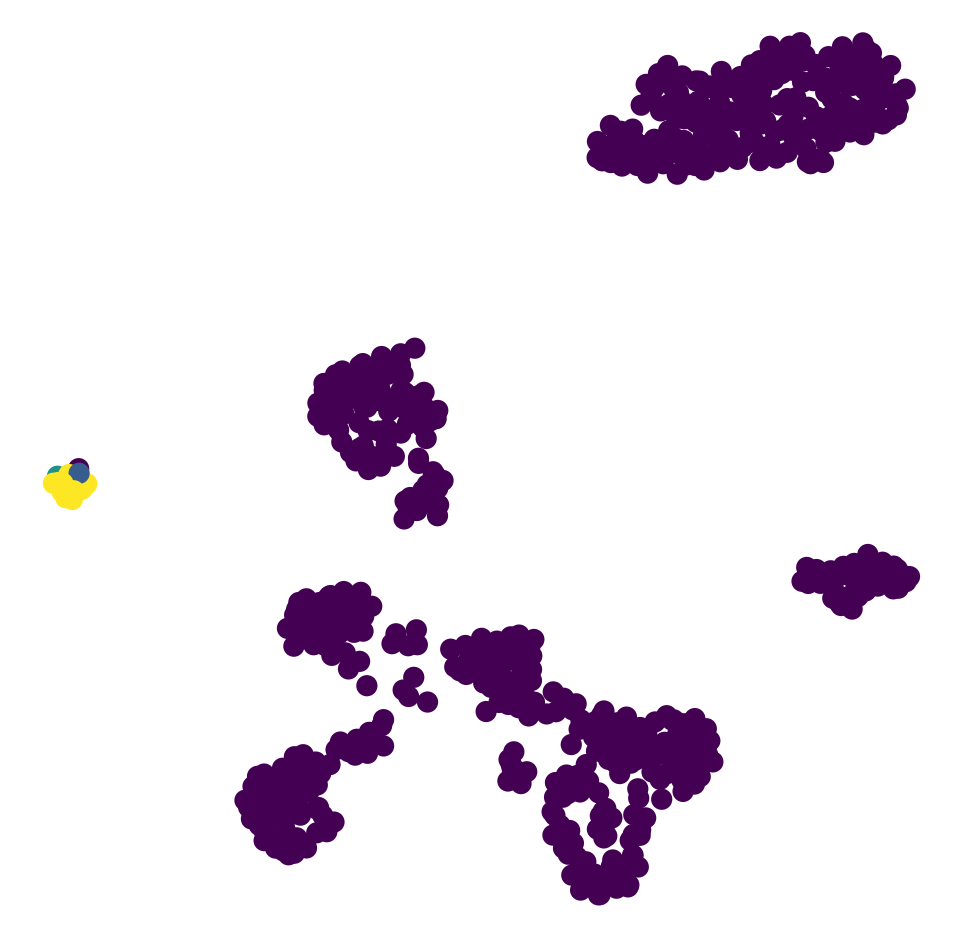

In [215]:
gene = 'Retnlg'
expr = sc2pd(X_IMM, 'norm').loc[gene]
coords = umap_IMM_pd
vmin = 0
vmax = 20
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 450,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_IMM_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

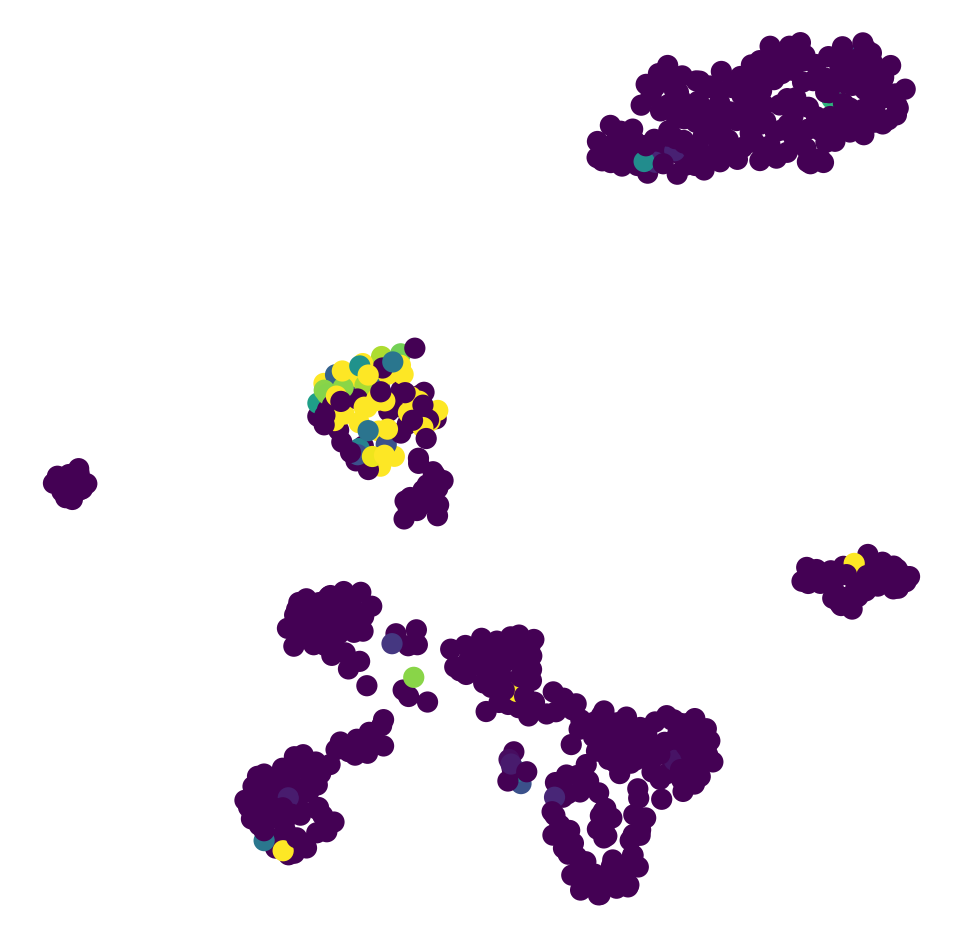

In [216]:
gene = 'Cd28'
expr = sc2pd(X_IMM, 'norm').loc[gene]
coords = umap_IMM_pd
vmin = 0
vmax = 5
cmap = plt.cm.viridis

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(coords[0]), np.max(coords[0])
y_min, y_max = np.min(coords[1]), np.max(coords[1])
x_diff, y_diff = x_max - x_min, y_max - y_min
x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

pad = 2

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

if x_diff < y_diff:
    xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad,)
    ylim = (y_min - pad, y_max + pad)
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

clist = [cmap((e-vmin)/(vmax-vmin)) for e in expr]
    
#plot

ax1.scatter(coords[0],
            coords[1], 
            s = 450,
            linewidth = 0.0,
            c = clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_IMM_expr_%s.pdf' % gene
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - vascular cells

## Classification

In [82]:
X_VASC = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_VASC.h5' % (path_output, exp_id))

In [83]:
umap_VASC_pd = pd.DataFrame(X_VASC.obsm['X_umap'], index = X_VASC.obs_names, columns = [0,1])

In [84]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'VASC']

scoring_2nd_VASC = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_VASC.index:
    scoring_2nd_VASC[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

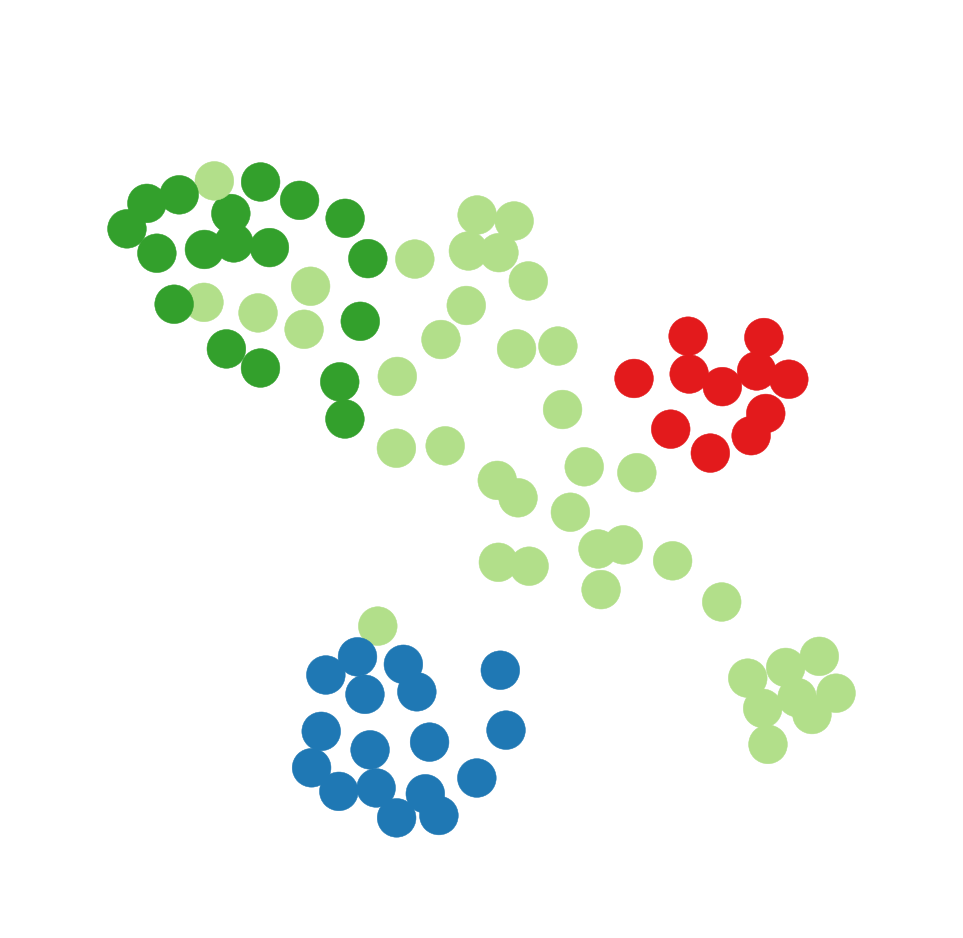

In [56]:
cells = scoring_2nd_VASC[X_VASC.obs_names]
tsne = umap_VASC_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 1500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

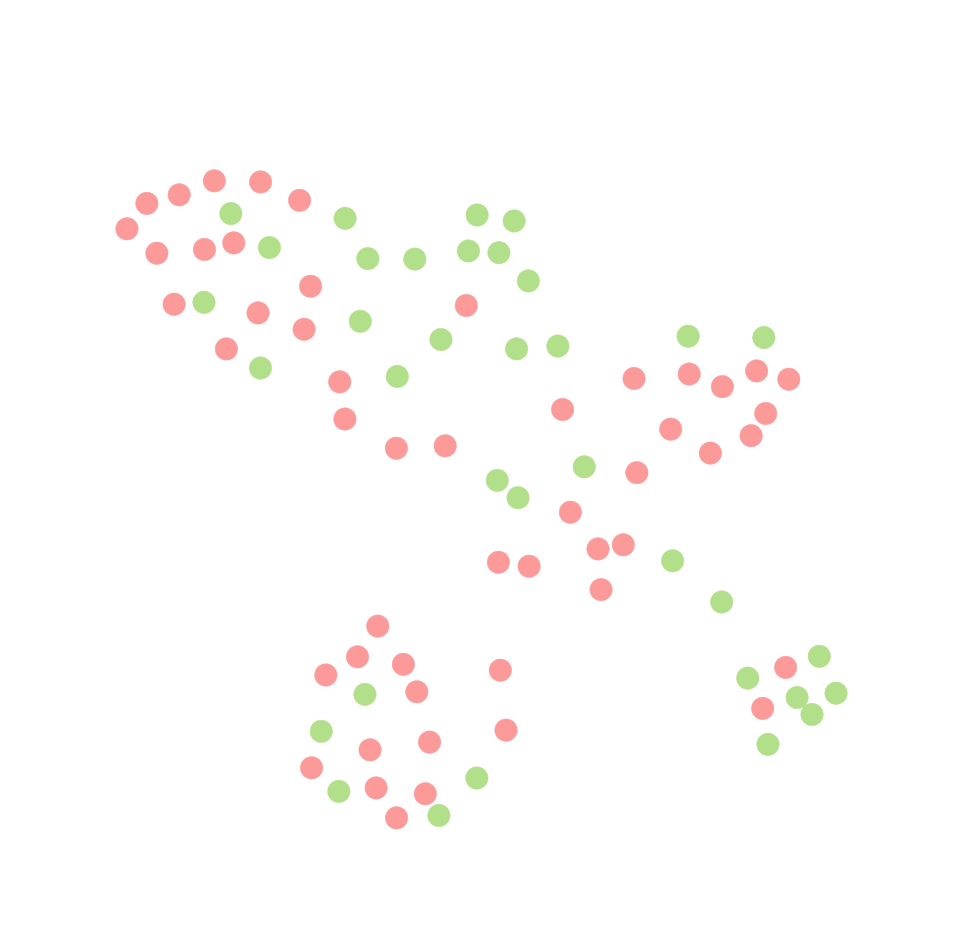

In [158]:
cells = X_VASC.obs['stage']
tsne = umap_VASC_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_stage_VASC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - neural crest derived cells

In [86]:
X_NC = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_NC.h5' % (path_output, exp_id))

In [87]:
umap_NC_pd = pd.DataFrame(X_NC.obsm['X_umap'], index = X_NC.obs_names, columns = [0,1])

In [88]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'MEL']

scoring_2nd_NC = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_NC.index:
    scoring_2nd_NC[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

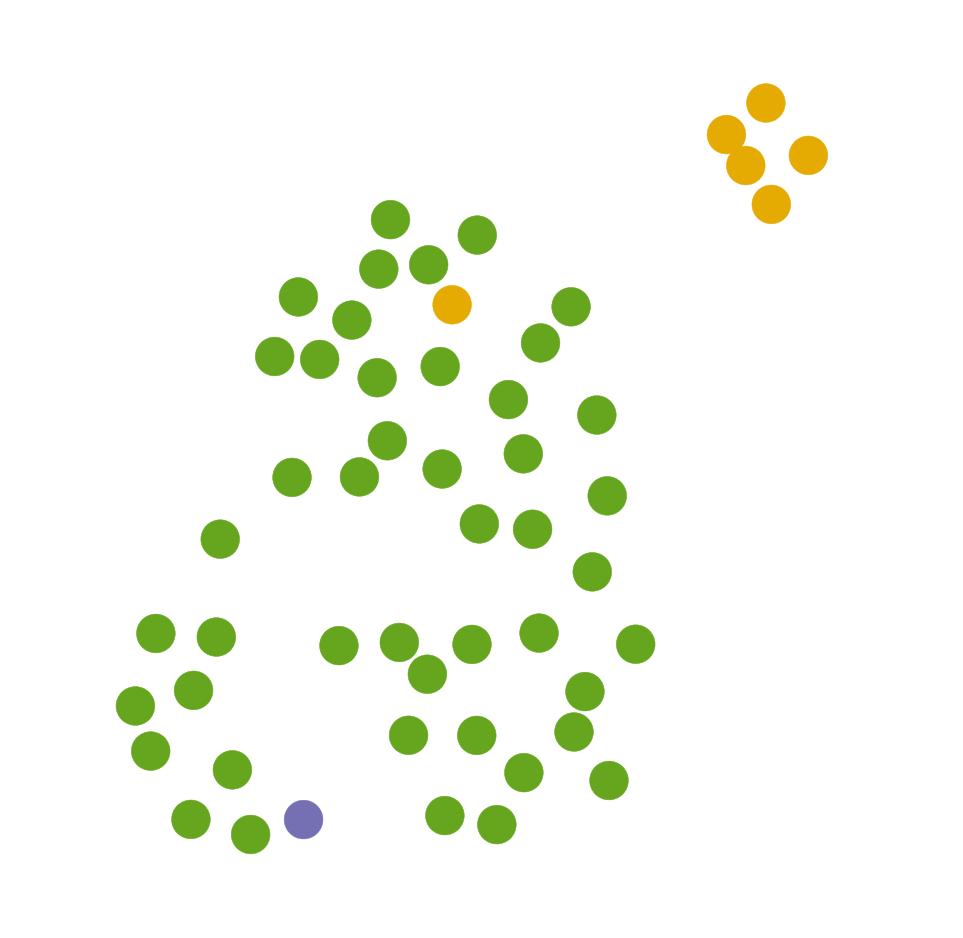

In [60]:
cells = scoring_2nd_NC[X_NC.obs_names]
tsne = umap_NC_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 1500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_NC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

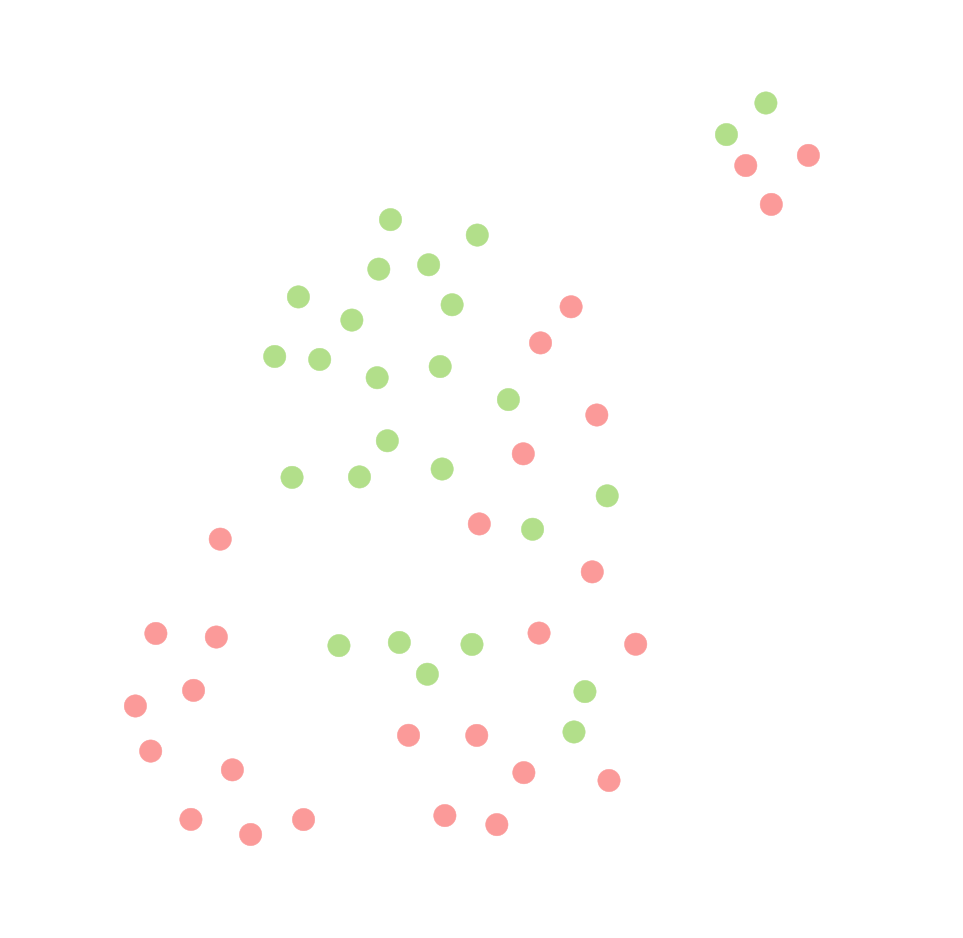

In [166]:
cells = X_NC.obs['stage']
tsne = umap_NC_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_stage_NC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# 2nd level clustering - miscellaneous

In [90]:
X_MISC = sc.read_h5ad('%s/%s_Xs_MKnew_2nd_MISC.h5' % (path_output, exp_id))

In [91]:
umap_MISC_pd = pd.DataFrame(X_MISC.obsm['X_umap'], index = X_MISC.obs_names, columns = [0,1])

In [92]:
ix_sel = [i for i in scoring_2nd.index if i.split(' - ')[0] == 'MISC']

scoring_2nd_MISC = pd.Series(index = scoring_2nd.columns)
for i in scoring_2nd_MISC.index:
    scoring_2nd_MISC[i] = scoring_2nd.loc[ix_sel,i].astype(float).sort_values().index[-1]

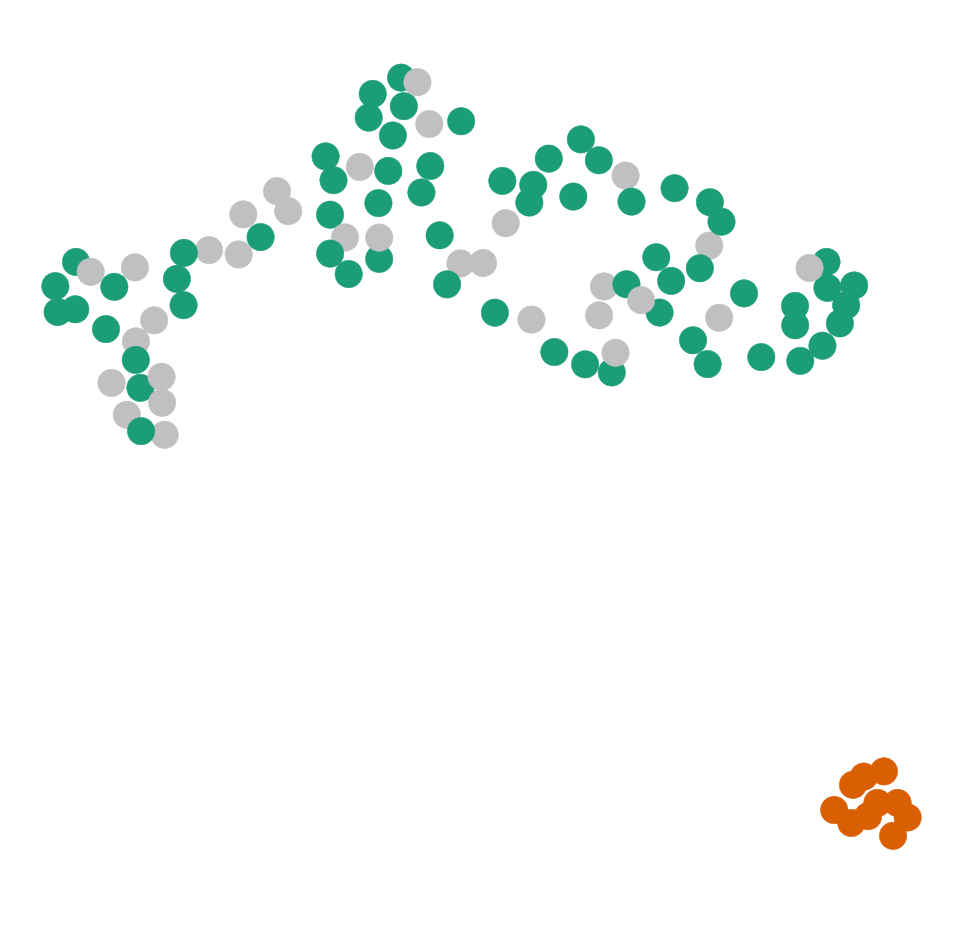

In [65]:
cells = scoring_2nd_MISC
tsne = umap_MISC_pd
cmap = cmap_2nd

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = []
for i in tsne.index:
    try:
        clist+=[cmap[cells[i]]]
    except: 
        clist += ['silver']

ax1.scatter(tsne[0],
            tsne[1], 
            s = 750,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

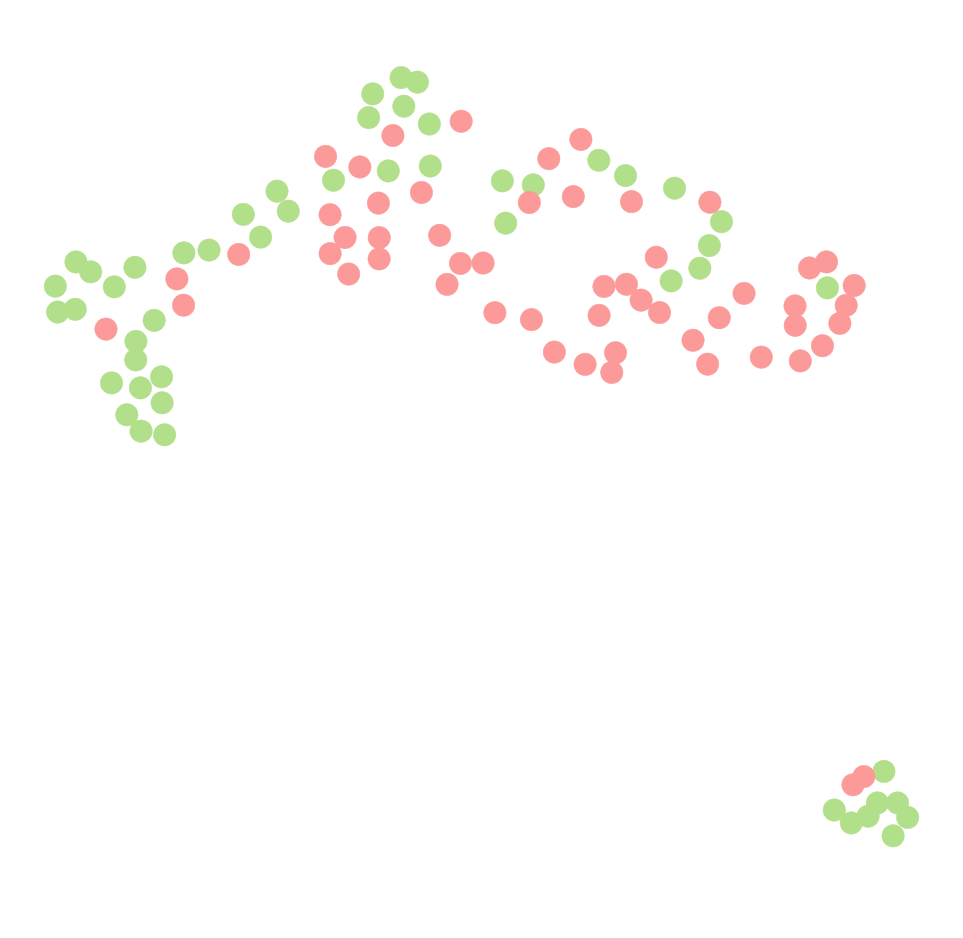

In [174]:
cells = X_MISC.obs['stage']
tsne = umap_MISC_pd
cmap = cmap_stage

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne[0]), np.max(tsne[0])
y_min, y_max = np.min(tsne[1]), np.max(tsne[1])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[cells[i]] for i in tsne.index]

ax1.scatter(tsne[0],
            tsne[1], 
            s = 500,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_FigS7_UMAP_class_MISC.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)